# Desafio de Ensembles: Previsão de _Churn_ de Clientes

___


### Allan Almeida Dieguez

> #### Tera / Luizalabs

#### Março de 2022

### André Kuniyoshi
___


# Contexto do Desafio



## *Churn* de Clientes

O desafio de prever se um cliente irá sair da Base de Clientes Ativos (também conhecido como *churn*) não é um problema exclusivo do varejo, sendo uma área de estudos constante da maioria das indústrias e empresas de serviços que dependem da retenção. 

Esse é um exemplo do tipo de problema que um cientista do *Chapter* de Ciência de Dados do Luizalabs entra de cabeça e cujas soluções servem para alavancar várias frentes de trabalho. A solução em si já traz muito valor, se tiver alto índice de acertos pode ser usada para elencar automaticamente clientes com alto risco de *churn* para uma promoção agressiva com o objetivo retê-lo na base. 

Também há muito valor nos *insights* e na validação de hipóteses que acontece durante o processo de análise do problema e das soluções. Pode-se verificar através de experimentação que, por exemplo, um cliente que compra exclusivamente em datas especiais ou eventos promocionais tem uma chance menor de ser um *churn* do que um que compra grandes volumes do mesmo produto. 

## Objetivos do Desafio

Nesse desafio, construído em uma parceria da **Tera** e o **Luizalabs**, o **objetivo principal** será construir algumas soluções baseadas em *machine learning* para prever se um dado cliente do *e-commerce* do **Magalu** continuará comprando na plataforma em 2020 usando algumas características próprias do cliente e seu histórico de compras no ano anterior. No final, algumas dessas soluções devem ser combinadas em um *ensemble* para criar uma solução única com o objetivo de alavancar ainda mais os resultados.

Para que o **objetivo principal** seja cumprido, será necessário construir uma forma de visualização das soluções criadas e a comparação com o **modelo _baseline_** e com o **modelo de _ensemble_** criados no processo. O formato sugerido é um **tabela de resultados** contendo as métricas de sucesso de cada modelo criado.

O **objetivo secundário** é o levantamento de hipóteses e *insights* que surgirem durante as experimentações. É interessante fazer isso desde o início como parte da análise exploratória, documentando qualquer indício de informação nova sobre o problema. Também é uma boa prática avaliar os modelos treinados, seja através da exploração de seus parâmetros (por exemplo, os pesos de um modelo linear) ou usando técnicas avançadas como o [SHAP](https://www.kaggle.com/dansbecker/shap-values), buscando relacionar como as _features_ influenciam as respostas do modelo.

A forma mais simples de cumprir o **objetivo secundário** é a documentação das etapas de análise e exploração de forma resumida em um relatório que compila as principais hipóteses e _insights_. Esse relatório pode ser um documento de texto na forma de um **diário de bordo** ou mesmo uma **seção do próprio notebook** em que a solução foi desenvolvida.

## Pontuação no Desafio

O desafio também possui um **_dataset_ de pontuação**, contendo dados de clientes que não estão nem nas bases de treino nem nas de teste. Para esses clientes não foram disponibilizadas as respostas (_targets_), sendo portanto impossível verificar durante o desenvolvimento da solução se o modelo está acertando ou não. 

O objetivo desse _dataset_ é permitir, de forma justa, que os alunos possam comparar suas melhores soluções com as dos outros. Através desse [_link_](https://forms.gle/9Vb4VDVejXLz6wi67) é possível fazer o envio do **arquivo de respostas** do desafio. No fim do desafio, será mostrado o _ranking_ dos envios dos alunos. 

_Let the Games Begin!_ =

# Base de Dados

Todos os dados disponibilizados para esse desafio estão em arquivos no formato **_csv_**, podendo ser baixados para serem trabalhados localmente ou em um notebook do **_Google Colab_** como este aqui. 

Os dados sensíveis ou privados de clientes e produtos estão todos anonimizados, respeitando a privacidade dos mesmos e evitando o vazamento de informações estratégicas da empresa. 

Esses dados anonimizados incluem informações de **IDs de entidades** (clientes, vendas e produtos), os **estados** de origem do cliente e de destino do produto e a **estrutura mercadológica** dos produtos (nomes de categorias e subcategorias às quais pertencem), assim como sua **descrição** (nome do produto incluso).



## Definições de Código

Algumas definições de ambiente serão definidas nessa seção para facilitar o acesso aos dados.

#### Imports

In [ ]:
import gdown
import numpy as np
import pandas as pd
import math

### Estrutura de pastas

Criação da estrutura de pastas antes do _download_.

In [ ]:
%%bash
if [  -d "data" ]
then 
    echo "folder 'data' already created, do nothing" 
else
    mkdir data
    echo "created 'data' folder"
fi

folder 'data' already created, do nothing


### URLs e Nomes de Arquivos

In [ ]:
FILE_INFO = {
    'client_tr': {
        'url':      'https://drive.google.com/uc?id=1GaDgzqFJz-ATMU5ePDD7BPjpSjzZ7kQm',
        'output':   'data/client.train.csv'
    },
    'client_te': {
        'url':      'https://drive.google.com/uc?id=1Pg6AIpM-krtf1aNS3IKUSkoHhun_OxKw',
        'output':   'data/client.test.csv'
    },
    'client_ch': {
        'url':      'https://drive.google.com/uc?id=1JBo7SlIuzmkQgRg9VytkNgXLhZyKmPJV',
        'output':   'data/client.challenge.csv'
    },
    'orders': {
        'url':      'https://drive.google.com/uc?id=1sk7p66kMAu4ZfAUmYVH0YF-cx2kHd4UZ',
        'output':   'data/orders.csv'
    },
    'product': {
        'url':      'https://drive.google.com/uc?id=1wU65H2mwrdd8BhVM8hITCB9sfRVNHFwQ',
        'output':   'data/product.csv'
    }
}

## Descrição das Tabelas e Colunas

Nessa seção serão descritas as tabelas e suas colunas do desafio. Os links para os arquivos e a descrição de cada um está nas seções a seguir. Algumas definições de código e extrações já serão feitas nesse momento, para facilitar o uso dos dados no restante do _notebook_ e para facilitar a explicação de cada elemento.

### Dados de Clientes

Os dados de clientes estão contidos em **3 arquivos** _csv_ já separados em **treino**, **teste** e **desafio**. Isso foi feito previamente para que os três _datasets_ tivessem distribuições justas das **_features_ de interesse**, representando fielmente o domínio do problema.

#### Colunas das Tabelas

As colunas para os três arquivos são:

- `client_id`: ID global único do cliente
- `birthdate`: data de nascimento do cliente
- `state`: estado onde o cliente mora
- `gender`: gênero declarado pelo cliente
- `is_churn`: variável dependente (_target_) que diz se o cliente será _churn_ ou não

#### Dados de Treino: _clients.train.csv_

Os **dados de treino** estão [neste arquivo](https://drive.google.com/uc?id=1Pg6AIpM-krtf1aNS3IKUSkoHhun_OxKw) do _Google Drive_.

In [ ]:
key = 'client_tr'

In [ ]:
 gdown.download(**FILE_INFO[key], quiet=0)

Downloading...
From: https://drive.google.com/uc?id=1GaDgzqFJz-ATMU5ePDD7BPjpSjzZ7kQm
To: /content/data/client.train.csv
100%|██████████| 788k/788k [00:00<00:00, 93.4MB/s]


'data/client.train.csv'

In [ ]:
clients_tr = pd.read_csv(
    FILE_INFO[key]['output'],
    index_col=0, 
    sep=',', 
    encoding='utf-8',
    parse_dates=['birthdate']
)
clients_tr

,birthdate,state,gender,is_churn
client_id,,,,
cx05072,1972-03-22,st25,cg2,False
cx03836,1966-08-14,st15,cg1,False
cx08472,1954-08-07,st15,cg1,False
cx12946,1955-11-16,st15,cg1,False
cx19045,1958-10-25,st15,cg2,False
...,...,...,...,...
cx05312,1981-08-29,st18,cg1,False
cx02434,1997-03-15,st04,cg2,False
cx16024,1950-10-09,st11,cg1,False


#### Dados de Teste: _clients.test.csv_

Os **dados de teste** estão [neste arquivo](https://drive.google.com/uc?id=1Pg6AIpM-krtf1aNS3IKUSkoHhun_OxKw) do _Google Drive_.

In [ ]:
key = 'client_te'

In [ ]:
 gdown.download(**FILE_INFO[key], quiet=0)

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1Pg6AIpM-krtf1aNS3IKUSkoHhun_OxKw 



In [ ]:
clients_te = pd.read_csv(
    FILE_INFO[key]['output'],
    index_col=0, 
    sep=',', 
    encoding='utf-8',
    parse_dates=['birthdate']
)
clients_te

,birthdate,state,gender,is_churn
client_id,,,,
cx06840,1982-12-03,st15,cg1,False
cx01931,1979-05-09,st15,cg1,False
cx35431,1965-05-09,st15,cg1,False
cx36233,1954-03-15,st15,cg2,False
cx13540,1965-06-19,st15,cg1,False
...,...,...,...,...
cx19119,1980-05-31,st24,cg1,False
cx21963,1984-08-25,st15,cg2,False
cx37195,1960-01-16,st13,cg2,False


#### Dados de Desafio: _clients.challenge.csv_

Os **dados de desafio** estão [neste arquivo](https://drive.google.com/uc?id=1JBo7SlIuzmkQgRg9VytkNgXLhZyKmPJV) do _Google Drive_. Interessante notar que está faltando a coluna `is_churn`, que não será fornecida para esse _dataset_.

In [ ]:
key = 'client_ch'

In [ ]:
 gdown.download(**FILE_INFO[key], quiet=0)

Downloading...
From: https://drive.google.com/uc?id=1JBo7SlIuzmkQgRg9VytkNgXLhZyKmPJV
To: /content/data/client.challenge.csv
100%|██████████| 217k/217k [00:00<00:00, 67.2MB/s]


'data/client.challenge.csv'

In [ ]:
clients_ch = pd.read_csv(
    FILE_INFO[key]['output'],
    index_col=0, 
    sep=',', 
    encoding='utf-8',
    parse_dates=['birthdate']
)
clients_ch

,birthdate,state,gender
client_id,,,
cx12525,1932-04-19,st15,cg1
cx32280,1983-03-01,st15,cg1
cx00471,1964-08-30,st15,cg2
cx18876,1971-04-27,st15,cg2
cx38255,1958-01-26,st15,cg1
...,...,...,...
cx37820,1980-05-01,st04,cg1
cx00770,1964-10-12,st18,cg2
cx01686,1972-07-20,st24,cg2


### Dados de Produtos

Os **dados de produto** estão [neste arquivo](https://drive.google.com/uc?id=1wU65H2mwrdd8BhVM8hITCB9sfRVNHFwQ) do _Google Drive_.

In [ ]:
key = 'product'

In [ ]:
 gdown.download(**FILE_INFO[key], quiet=0)

Downloading...
From: https://drive.google.com/uc?id=1wU65H2mwrdd8BhVM8hITCB9sfRVNHFwQ
To: /content/data/product.csv
100%|██████████| 950k/950k [00:00<00:00, 110MB/s]


'data/product.csv'

In [ ]:
product = pd.read_csv(
    FILE_INFO[key]['output'],
    index_col=0, 
    sep=',', 
    encoding='utf-8'
)
product

,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
product_id,,,,,
px01237,mk38,mk38:072,mk38:072:149,mk38:072:149:218,mk38:072:149:218:04846
px11510,mk38,mk38:072,mk38:072:149,mk38:072:149:218,mk38:072:149:218:01337
px03782,mk38,mk38:072,mk38:072:019,mk38:072:019:066,mk38:072:019:066:02321
px04092,mk38,mk38:072,mk38:072:019,mk38:072:019:054,mk38:072:019:054:06035
px07429,mk38,mk38:072,mk38:072:078,mk38:072:078:182,mk38:072:078:182:07218
...,...,...,...,...,...
px11965,mk35,mk35:072,mk35:072:122,mk35:072:122:182,mk35:072:122:182:00392
px05192,mk35,mk35:072,mk35:072:122,mk35:072:122:182,mk35:072:122:182:02028
px05391,mk38,mk38:107,mk38:107:357,mk38:107:357:182,mk38:107:357:182:08006


As colunas da Tabela de Produtos são todas simbólicas, representando as diferentes categorias da **árvore de Estrutura Mercadológica** onde o produto está inserido. 

Os nomes das subcategorias herdam o nome da categoria pai, de forma que todas as subcategorias da coluna `category_lv2` que começam com "mk38:072" possuem como categoria pai a `category_lv1` de nome "mk38:072", que por sua vez é filho da `category_lv0` de nome "mk38".

Um exemplo da categorização:

- `category_lv0`: Categorias mais abrangentes dos produtos; e.g. "Eletrônicos" ou "Moda"
- `category_lv1`: Subcategorias; e.g. "Eletrônicos->Notebooks"
- `category_lv2`: Sub-subcategorias; e.g. "Eletrônicos->Notebooks->UltraFinos"

e assim por diante.

A coluna `product_id` é a referência global de produtos, que pode ser combinada por _merge_ com a tabela de vendas.

### Histórico de Vendas

Os **dados do histórico de todas as vendas** de 2019 para **todos os clientes** nos 3 datasets de cliente que compraram qualquer produto - todos contidos no dataset de produtos - estão [neste arquivo](https://drive.google.com/uc?id=1sk7p66kMAu4ZfAUmYVH0YF-cx2kHd4UZ) do _Google Drive_.

In [ ]:
key = 'orders'

In [ ]:
 gdown.download(**FILE_INFO[key], quiet=0)

Downloading...
From: https://drive.google.com/uc?id=1sk7p66kMAu4ZfAUmYVH0YF-cx2kHd4UZ
To: /content/data/orders.csv
100%|██████████| 13.3M/13.3M [00:00<00:00, 118MB/s]


'data/orders.csv'

In [ ]:
orders = pd.read_csv(
    FILE_INFO[key]['output'],
    index_col=0, 
    sep=',', 
    encoding='utf-8',
    parse_dates=['datetime']
)
orders

,client_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source
order_id,,,,,,,,,,,
ox008433,cx05072,px04611,2019-10-07 15:20:00,1.0,49.90,pm05,NaN,NaN,st07,dv9,sc08
ox070389,cx05072,px12305,2019-10-11 17:42:00,1.0,69.90,pm05,NaN,NaN,st07,dv9,sc08
ox061137,cx06840,px07033,2019-01-19 13:09:00,1.0,35.90,pm05,NaN,NaN,st07,dv9,sc08
ox061137,cx06840,px05992,2019-01-19 13:09:00,3.0,35.90,pm05,NaN,NaN,st07,dv9,sc08
ox038612,cx06840,px10040,2019-04-18 14:36:00,1.0,39.00,pm05,NaN,NaN,st07,dv9,sc08
...,...,...,...,...,...,...,...,...,...,...,...
ox081422,cx15796,px08541,2019-06-25 11:50:00,1.0,246.50,pm14,10.0,21.0,st01,dv5,sc11
ox081422,cx15796,px05166,2019-06-25 11:50:00,1.0,652.50,pm14,10.0,21.0,st01,dv5,sc11
ox128219,cx15796,px12043,2019-09-06 11:45:00,2.0,15.00,pm05,NaN,NaN,st07,dv9,sc08


As colunas dessa tabela estão descritas a seguir.

As colunas de ID de entidade são:
- `order_id`: identificador da venda; pode estar repetida em outras linhas, pois **cada linha corresponde à compra de um produto por um cliente**, que pode ter comprado outros produtos no mesmo evento.
- `client_id`: identificador do cliente que realizou a compra
- `datetime`: data e hora da compra
- `units`: quantidade de unidades do produto que foram comprados nesse evento de compra
- `price`: preço unitário do produto comprado
- `payment_method`: forma de pagamento (crétido, débito, _voucher_, etc) da compra
- `installments`: número de parcelas do pagamento; se estiver vazio, pode-se considerar que não se aplica
- `delivery_days`: prazo de entrega do produto
- `delivery_state`: estado onde ocorreu a entrega do produto; corresponde exatamente ao estado nas tabelas de cliente
- `device`: meio por onde  o cliente comprou; e.g. site, aplicativo do celular, terminal de compras
- `source`: canal de _marketing_ que gerou o _lead_ e ocasionou ao cliente comprar; por exemplo, pode ser um link em uma página parceira onde o cliente viu uma promoção

# Roteiro Sugerido

As etapas a seguir são a sugestão de passos mínima para a solução do problema de forma estruturada. Em alguns passos serão dadas algumas sugestões de código para o melhor aproveitamento do esforço de exploração e construção de solução.

A idéia não é engessar a abordagem, mas apenas criar uma trilha minimamente estruturada para que seja fácil rastrear os passos da solução. O passo inicial será sempre a **análise exploratória** para entender os dados brutos, seguido por um ajuste dos elementos do dataset baseada nas descobertas em uma etapa de **limpeza e pré-processamento** dos dados.

## Análise Exploratória Inicial

O primeiro passo **sempre** deve ser uma boa EDA (ou análise exploratória). Deve-se entender em cada tabela fornecida a distribuição dos dados de cada coluna, o seu tipo e as correlações (no caso de _features_ numéricas) e co-ocorrências (para _features_ categóricas). Sempre é muito importante tentar entender a relação de todas as _features_ disponíveis com a **variável dependente** ou _target_ (no caso, `is_churn`, para entender se há variáveis que já explicam bem o comportamento da saída **antes mesmo de modelar** uma solução.

Sugestão para começar: pegar a tabela de **dados de cliente de treino** `client_tr` e fazer uma exploração das colunas de lá. Depois, buscar fazer uma análise exploratória nas **compras realizadas por esses clientes**, buscando perceber se há alguma relação interessante de comportamento do cliente. Por exemplo, pode-se verificar se o cliente sempre compra produtos para **entregar no mesmo estado em que ele mora**.

Muito importante usar as **técnicas de visualização** como histogramas e tabelas de correlações para ter as idéias certas. Nesses casos, gerar gráficos com as bibliotecas [matplotlib](https://matplotlib.org/) e a [seaborn](https://seaborn.pydata.org/) sempre é muito rico. Quando trabalhar com gráficos, sempre seguir a **regra de ouro**: se um gráfico **não mostra explicitamente o comportamento** que quer observar, a análise por esse gráfico pode não ser interessante, siga adiante para outra visualização.

Mais uma sugestão de feramentas: além da biblioteca `pandas`, as bibliotecas `numpy` e `scikit-learn` também possuem muitas ferramentas de análise interessantes.

### Algumas funções para ajudar nas análises

In [ ]:
def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()-0.8
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 8)

In [ ]:
''' sugestão de imports '''
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import numpy as np

from scipy import stats

In [ ]:
clients_tr.head()

,birthdate,state,gender,is_churn
client_id,,,,
cx05072,1972-03-22,st25,cg2,False
cx03836,1966-08-14,st15,cg1,False
cx08472,1954-08-07,st15,cg1,False
cx12946,1955-11-16,st15,cg1,False
cx19045,1958-10-25,st15,cg2,False


In [ ]:
# dados do dataset de treino
clients_tr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23292 entries, cx05072 to cx00861
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   birthdate  23292 non-null  datetime64[ns]
 1   state      23292 non-null  object        
 2   gender     23292 non-null  object        
 3   is_churn   23292 non-null  bool          
dtypes: bool(1), datetime64[ns](1), object(2)
memory usage: 750.6+ KB


### Base CLIENTES - TREINO

In [ ]:
# importando warnings filter
from warnings import simplefilter
# ignorar warnings
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
def outliers(df, feature):

    FIQ = df[feature].quantile(0.75) - df[feature].quantile(0.25)
    outliers_sup = df[feature].quantile(0.75) + FIQ
    outliers_inf = df[feature].quantile(0.25) - FIQ
    return print('outliers superiores:',
                 round((df[feature] > outliers_sup).sum()/len(df[feature])*100,2),'%'), print('outliers inferiores:',
                                                                                              round((df[feature] < outliers_inf).sum()/len(df[feature])*100,2),'%')

#### Data de Nascimento

Mediana do ano de nascimento: 1979.0


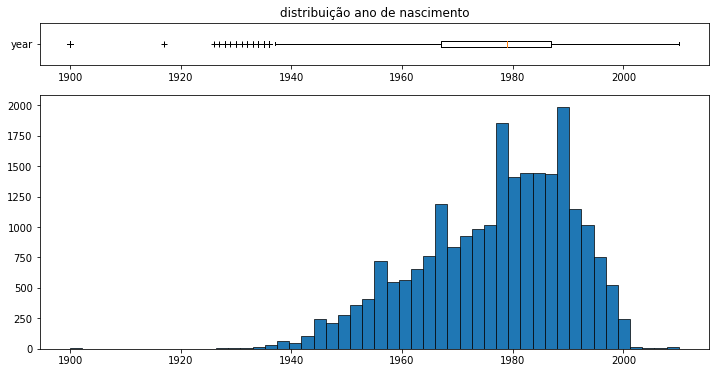

In [ ]:
# criando histograma de data de nascimento
# porém, considerando somente o ano
print('Mediana do ano de nascimento:', clients_tr.birthdate.dt.year.median())

fig = plt.figure(figsize=(12, 6)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 6]) 

ax0 = plt.subplot(gs[0])
ax0.boxplot(clients_tr.birthdate.dt.year,
            vert=False,
            sym = '+',
            )
ax0.set_yticklabels(['year'])
ax0.set_title("distribuição ano de nascimento")

ax1 = plt.subplot(gs[1])
ax1 = clients_tr.birthdate.dt.year.hist(bins=50,
                                        edgecolor='black',
                                        linewidth=0.7,
                                        grid=False)

fig.show()
#sns.histplot(clients_tr.birthdate.dt.year)

A curva de ano de nascimento é assimétrica à esquerda e possui mediana de 1979

In [ ]:
# verificando a distribuição de ano de nascimento, por determinados percentis
clients_tr.birthdate.dt.year.describe(percentiles=[.05, .25, .50, .75, .95])

count    23292.000000
mean      1976.765585
std         13.702858
min       1900.000000
5%        1951.000000
25%       1967.000000
50%       1979.000000
75%       1987.000000
95%       1995.000000
max       2010.000000
Name: birthdate, dtype: float64

In [ ]:
outliers(clients_tr, 'birthdate')

outliers superiores: 0.07 %
outliers inferiores: 2.72 %


(None, None)

#### Estado

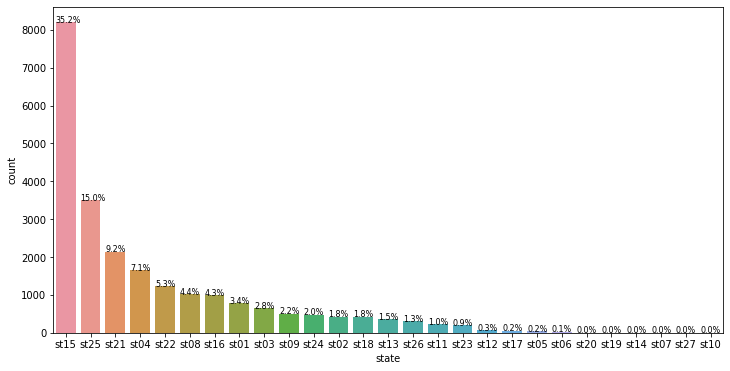

In [ ]:
# plotando a distribuição de estados
plt.figure(figsize = (12,6))
ax = sns.countplot(x = 'state',
                   data = clients_tr,
                   order = clients_tr.state.value_counts().index)
without_hue(ax, clients_tr['state'])

Mais de 35% dos clientes pertencem ao estado st15. O segundo estado que mais possui clientes é o st25, com 15% do total

#### Gênero

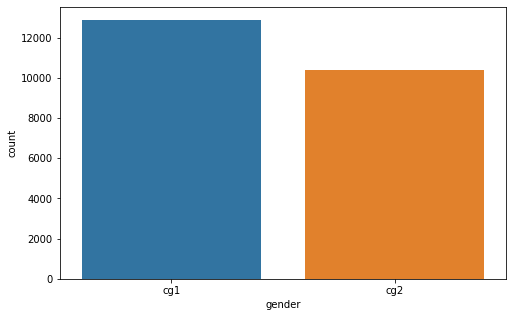

In [ ]:
# plotando a distribuição de gênero
plt.figure(figsize = (8,5))
ax = sns.countplot(x = 'gender',
                   data = clients_tr,
                   order = clients_tr.gender.value_counts().index)

In [ ]:
# verificando percentualmente
clients_tr.gender.value_counts(normalize=True)

cg1    0.552937
cg2    0.447063
Name: gender, dtype: float64

#### CHURN

In [ ]:
clients_tr.is_churn

client_id
cx05072    False
cx03836    False
cx08472    False
cx12946    False
cx19045    False
           ...  
cx05312    False
cx02434    False
cx16024    False
cx11285    False
cx00861    False
Name: is_churn, Length: 23292, dtype: bool

Primeiro, vamos trocar os valoes de False e True por 0 e 1 no nosso dataset.

Antes disso, vou fazer uma cópia do dataset original

In [ ]:
clients_tr_analise = clients_tr.copy()

In [ ]:
dict = {False:0,
        True:1}

clients_tr_analise['is_churn'] = clients_tr_analise['is_churn'].map(dict)

In [ ]:
clients_tr_analise['is_churn'].value_counts()

0    19085
1     4207
Name: is_churn, dtype: int64

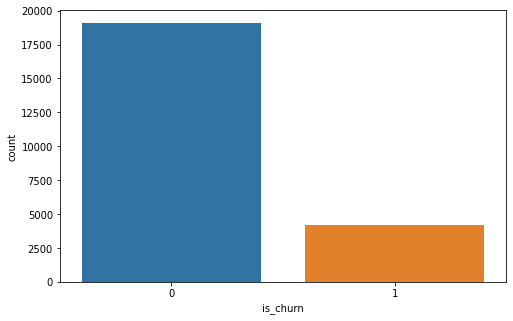

In [ ]:
# plotando a distribuição de churn
plt.figure(figsize = (8,5))
ax = sns.countplot(x = 'is_churn',
                   data = clients_tr_analise,
                   order = clients_tr_analise.is_churn.value_counts().index)

In [ ]:
# verificando percentualmente
clients_tr_analise.is_churn.value_counts(normalize=True)

0    0.81938
1    0.18062
Name: is_churn, dtype: float64

Como esperado, estamos trabalhando com dados desbalanceados.

cerca de 82% dos clientes não representam churn, enquanto 18% representam

##### CHURN vs Ano Nascimento

Para churn = 0, mediana: 1980.0
Para churn = 1, mediana: 1976.0


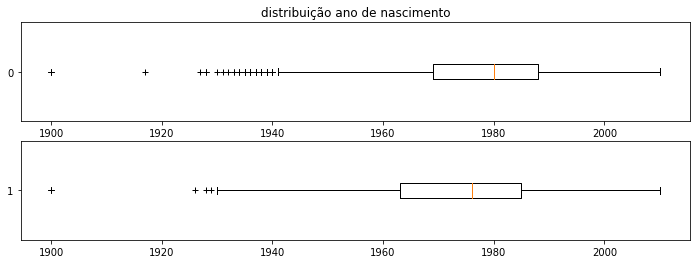

In [ ]:
# distribuição de ano nascimento para churn = 0 e = 1

print('Para churn = 0, mediana:', clients_tr_analise[clients_tr_analise.is_churn==0].birthdate.dt.year.median())
print('Para churn = 1, mediana:', clients_tr_analise[clients_tr_analise.is_churn==1].birthdate.dt.year.median())

fig = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

ax0 = plt.subplot(gs[0])
ax0.boxplot(clients_tr_analise[clients_tr_analise.is_churn==0].birthdate.dt.year,
            vert=False,
            sym = '+',
            )
ax0.set_yticklabels(['0'])
ax0.set_title("distribuição ano de nascimento")

ax1 = plt.subplot(gs[1])
ax1.boxplot(clients_tr_analise[clients_tr_analise.is_churn==1].birthdate.dt.year,
            vert=False,
            sym = '+',
            )
ax1.set_yticklabels(['1'])

fig.show()

In [ ]:
# Verificando se as medianas são estatisticamente diferentes
x = clients_tr_analise[clients_tr_analise.is_churn==0].birthdate.dt.year
y = clients_tr_analise[clients_tr_analise.is_churn==1].birthdate.dt.year
stats.kruskal(x, y)

KruskalResult(statistic=207.2326504360983, pvalue=5.516221640184417e-47)

Estatisticamente, as medianas dos anos de nascimento são iguais para churn = 0 e = 1

##### CHURN vs Estado

In [ ]:
# Criando um dataframe com info de estado e churn somente
data = {'state': clients_tr_analise.state.unique(),
        'churn0': clients_tr_analise[clients_tr_analise.is_churn==0].groupby('state')['is_churn'].count(),
        'churn1': clients_tr_analise[clients_tr_analise.is_churn==1].groupby('state')['is_churn'].count()}
clients_tr_analise_churn = pd.DataFrame(data)
clients_tr_analise_churn['total'] = clients_tr_analise_churn['churn0'] + clients_tr_analise_churn['churn1']
clients_tr_analise_churn['porc_churn0'] = clients_tr_analise_churn['churn0']/clients_tr_analise_churn['total']
clients_tr_analise_churn['porc_churn1'] = clients_tr_analise_churn['churn1']/clients_tr_analise_churn['total']
clients_tr_analise_churn

,state,churn0,churn1,total,porc_churn0,porc_churn1
state,,,,,,
st01,st25,680,106.0,786.0,0.865140,0.134860
st02,st15,353,77.0,430.0,0.820930,0.179070
st03,st04,540,111.0,651.0,0.829493,0.170507
st04,st26,1369,277.0,1646.0,0.831713,0.168287
st05,st13,33,3.0,36.0,0.916667,0.083333
st06,st19,26,2.0,28.0,0.928571,0.071429
st07,st12,2,NaN,NaN,NaN,NaN
st08,st08,826,195.0,1021.0,0.809011,0.190989
st09,st05,414,91.0,505.0,0.819802,0.180198


In [ ]:
# dropando as linhas com dados faltantes
# como são poucos os dados, não temos problemas com isso
clients_tr_analise_churn.dropna(inplace=True)

Text(0.5, 1.0, 'Porcentagem de churn por estado')

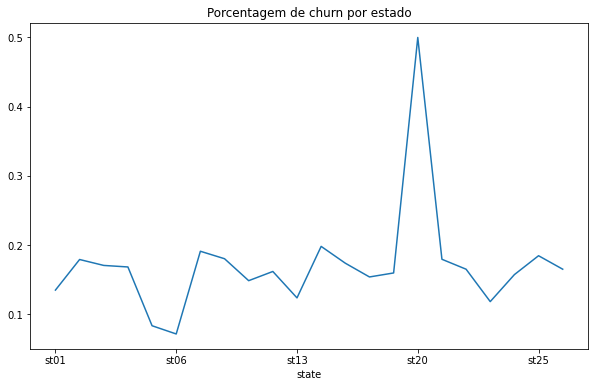

In [ ]:
plt.figure(figsize = (10,6))
ax = clients_tr_analise_churn.porc_churn1.plot(kind='line')
ax.set_title('Porcentagem de churn por estado')

Observa-se que há variedade de porcentagens de churn por estado. O St20 é o que apresenta maior valor, com 50%. Porém sua amostra é pequena, sendo 4 no total.

##### CHURN vs Gênero

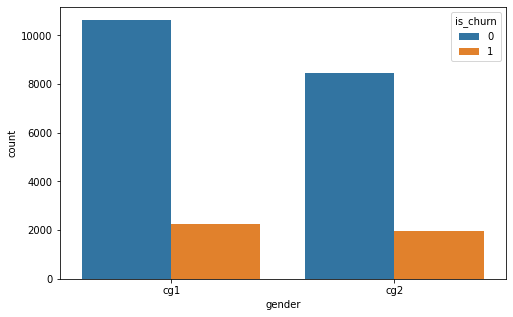

In [ ]:
plt.figure(figsize = (8,5))
ax = sns.countplot(clients_tr_analise.gender,
                   hue = clients_tr_analise.is_churn,
                   order = ['cg1', 'cg2'])

In [ ]:
# groupby para contar churns separados por sexo do cliente
clients_tr_analise.groupby('gender')['is_churn'].value_counts()

gender  is_churn
cg1     0           10632
        1            2247
cg2     0            8453
        1            1960
Name: is_churn, dtype: int64

Da base de treino de clientes, a princípio, temos:


* As distribuições de ano de nascimento para churn=0 e =1 são similares estatisticamente
* Há variação de porcentagem de churn por estado. O estado st20 apresenta metade de clientes como churn, porém possui somente 4 dados.
* Há variação de porcentagem de churn por gênero. O gênero cg2 aparenta maior propensão a churn



### Base ORDERS e PRODUCT - TREINO total

In [ ]:
orders.head()

,client_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source
order_id,,,,,,,,,,,
ox008433,cx05072,px04611,2019-10-07 15:20:00,1.0,49.9,pm05,NaN,NaN,st07,dv9,sc08
ox070389,cx05072,px12305,2019-10-11 17:42:00,1.0,69.9,pm05,NaN,NaN,st07,dv9,sc08
ox061137,cx06840,px07033,2019-01-19 13:09:00,1.0,35.9,pm05,NaN,NaN,st07,dv9,sc08
ox061137,cx06840,px05992,2019-01-19 13:09:00,3.0,35.9,pm05,NaN,NaN,st07,dv9,sc08
ox038612,cx06840,px10040,2019-04-18 14:36:00,1.0,39.0,pm05,NaN,NaN,st07,dv9,sc08


In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168472 entries, ox008433 to ox079633
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   client_id       168472 non-null  object        
 1   product_id      168472 non-null  object        
 2   datetime        168472 non-null  datetime64[ns]
 3   units           168472 non-null  float64       
 4   price           168472 non-null  float64       
 5   payment_method  168472 non-null  object        
 6   installments    36545 non-null   float64       
 7   delivery_days   89642 non-null   float64       
 8   delivery_state  168472 non-null  object        
 9   device          168472 non-null  object        
 10  source          168472 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(6)
memory usage: 15.4+ MB


In [ ]:
orders.describe()

,units,price,installments,delivery_days
count,168472.000000,168472.000000,36545.000000,89642.000000
mean,1.228846,451.384291,4.551293,7.017938
std,1.504511,857.769280,4.704385,6.855334
min,0.000000,-8999.000000,1.000000,0.000000
25%,1.000000,39.900000,1.000000,2.000000
50%,1.000000,162.580000,3.000000,5.000000
75%,1.000000,699.000000,7.000000,9.000000
max,110.000000,25648.900000,24.000000,165.000000


Para fazer as análises, vamos copiar o dataset  e fazer um merge com a base de produtos

In [ ]:
orders_analise = orders.copy()

In [ ]:
orders_analise.reset_index(inplace=True)


In [ ]:
product_analise = product.reset_index()

In [ ]:
orders_product_analise = pd.merge(orders_analise,
                                  product_analise,
                                  how = 'inner',
                                  on = 'product_id')
orders_product_analise.head()

,order_id,client_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
0,ox008433,cx05072,px04611,2019-10-07 15:20:00,1.0,49.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
1,ox077361,cx18190,px04611,2019-12-10 17:16:00,1.0,49.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
2,ox076724,cx09976,px04611,2019-07-31 16:06:00,1.0,49.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
3,ox061978,cx11765,px04611,2019-03-08 11:56:00,1.0,49.90,pm05,NaN,6.0,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
4,ox089080,cx03223,px04611,2019-01-18 12:43:00,1.0,49.89,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294


Vamos trabalhar somente com as ordens realizadas pelos clientes da nossa base de treino

In [ ]:
orders_product_analise_tr = orders_product_analise[orders_product_analise.client_id.isin(clients_tr_analise.index.to_list())]

In [ ]:
print(orders_product_analise_tr.shape)
orders_product_analise_tr.head()

(101005, 17)


,order_id,client_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
0,ox008433,cx05072,px04611,2019-10-07 15:20:00,1.0,49.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
2,ox076724,cx09976,px04611,2019-07-31 16:06:00,1.0,49.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
4,ox089080,cx03223,px04611,2019-01-18 12:43:00,1.0,49.89,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
6,ox000246,cx38788,px04611,2019-06-21 11:22:00,1.0,49.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
8,ox040114,cx00593,px04611,2019-07-01 18:22:00,1.0,49.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294


In [ ]:
# criando um dataset de ordens e produtos, para clientes sem churn
orders_product_analise_tr_churn0 = orders_product_analise[orders_product_analise.client_id.isin(clients_tr_analise[clients_tr_analise.is_churn==0].index.to_list())]

In [ ]:
print(orders_product_analise_tr_churn0.shape)
orders_product_analise_tr_churn0.head()

(83941, 17)


,order_id,client_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
0,ox008433,cx05072,px04611,2019-10-07 15:20:00,1.0,49.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
2,ox076724,cx09976,px04611,2019-07-31 16:06:00,1.0,49.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
4,ox089080,cx03223,px04611,2019-01-18 12:43:00,1.0,49.89,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
6,ox000246,cx38788,px04611,2019-06-21 11:22:00,1.0,49.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
8,ox040114,cx00593,px04611,2019-07-01 18:22:00,1.0,49.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294


In [ ]:
# criando um dataset de ordens e produtos, para clientes com churn
orders_product_analise_tr_churn1 = orders_product_analise[orders_product_analise.client_id.isin(clients_tr_analise[clients_tr_analise.is_churn==1].index.to_list())]

In [ ]:
print(orders_product_analise_tr_churn1.shape)
orders_product_analise_tr_churn1.head()

(17064, 17)


,order_id,client_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
21,ox062213,cx03363,px12305,2019-10-10 14:21:00,1.0,-69.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:292,mk04:292:246,mk04:292:246:103,mk04:292:246:103:04338
22,ox062213,cx03363,px12305,2019-10-10 17:29:00,3.0,69.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:292,mk04:292:246,mk04:292:246:103,mk04:292:246:103:04338
23,ox005871,cx03363,px12305,2019-10-29 14:21:00,1.0,69.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:292,mk04:292:246,mk04:292:246:103,mk04:292:246:103:04338
34,ox073301,cx10675,px12305,2019-12-02 16:03:00,1.0,69.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:292,mk04:292:246,mk04:292:246:103,mk04:292:246:103:04338
63,ox010421,cx14784,px10040,2019-06-24 16:56:00,1.0,30.07,pm05,NaN,NaN,st07,dv9,sc08,mk17,mk17:251,mk17:251:555,mk17:251:555:070,mk17:251:555:070:01336


#### Orders ID

In [ ]:
print('total de ordens:',len(orders_product_analise_tr))
print('ordens únicas:', len(orders_product_analise_tr.order_id.unique()))

total de ordens: 101005
ordens únicas: 80190


#### Client ID

In [ ]:
print('total de ordens:',len(orders_product_analise_tr))
print('clientes únicos:', len(orders_product_analise_tr.client_id.unique()))

total de ordens: 101005
clientes únicos: 23292


##### Client Churn vs não Churn

In [ ]:
# estatísticas de quantidade de transações
# para clientes churn = 0
orders_product_analise_tr_churn0.client_id.value_counts().describe()

count    19085.000000
mean         4.398271
std          4.950561
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         98.000000
Name: client_id, dtype: float64

In [ ]:
# estatísticas de quantidade de transações
# para clientes churn = 1
orders_product_analise_tr_churn1.client_id.value_counts().describe()

count    4207.000000
mean        4.056097
std         3.054924
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        53.000000
Name: client_id, dtype: float64

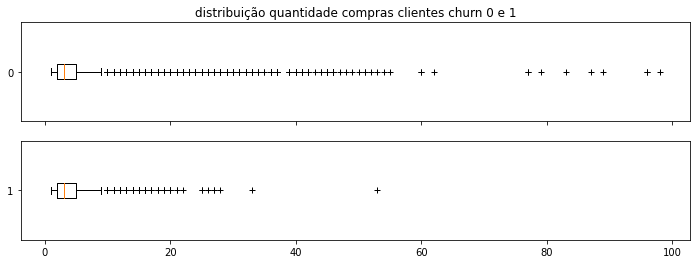

In [ ]:
fig, axs = plt.subplots(2,1, sharex=True, figsize = (12,4))

axs[0].boxplot(orders_product_analise_tr_churn0.client_id.value_counts(),
            vert=False,
            sym = '+',
            )
axs[0].set_yticklabels(['0'])
axs[0].set_title("distribuição quantidade compras clientes churn 0 e 1")

axs[1].boxplot(orders_product_analise_tr_churn1.client_id.value_counts(),
            vert=False,
            sym = '+',
            )
axs[1].set_yticklabels(['1'])

fig.show()

#### Product ID

In [ ]:
orders_product_analise_tr.product_id.value_counts()

px03347    1133
px10485    1128
px12043    1093
px10549    1089
px00532     535
           ... 
px11134       1
px11238       1
px08343       1
px06446       1
px06248       1
Name: product_id, Length: 10145, dtype: int64

Dos 168472 dados do dataset, temos 12535 produtos únicos.

In [ ]:
print('lv0 valores únicos:', len(orders_product_analise_tr.category_lv0.unique()))
print('lv1 valores únicos:', len(orders_product_analise_tr.category_lv1.unique()))
print('lv2 valores únicos:', len(orders_product_analise_tr.category_lv2.unique()))
print('lv3 valores únicos:', len(orders_product_analise_tr.category_lv3.unique()))
print('lv4 valores únicos:', len(orders_product_analise_tr.category_lv4.unique()))

lv0 valores únicos: 51
lv1 valores únicos: 277
lv2 valores únicos: 814
lv3 valores únicos: 1107
lv4 valores únicos: 8674


Quais são as categorias mais compradas?



*   Categoria lv0



In [ ]:
orders_product_analise_tr.category_lv0.value_counts()[:20]

mk21    17503
mk17    14343
mk29     7806
mk22     7419
mk16     6915
mk31     5963
mk25     4603
mk01     4258
mk44     3261
mk10     3090
mk04     3029
mk03     2989
mk28     2455
mk37     1701
mk07     1693
mk50     1622
mk23     1541
mk20     1224
mk06     1208
mk30     1073
Name: category_lv0, dtype: int64

Text(0, 0.5, '')

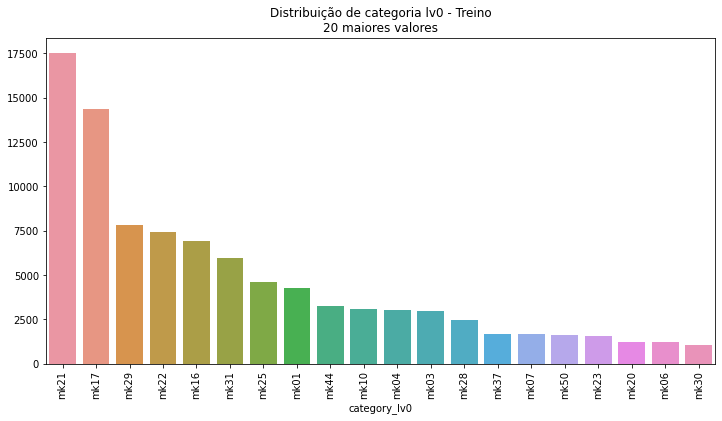

In [ ]:
plt.figure(figsize = (12, 6))
plt.xticks(rotation = 90)
plt.title('Distribuição de categoria lv0 - Treino\n20 maiores valores')
sns.countplot(orders_product_analise_tr.category_lv0,
              order = orders_product_analise_tr.category_lv0.value_counts().iloc[:20].index)
plt.ylabel('')



*   Categoria lv1



Text(0, 0.5, '')

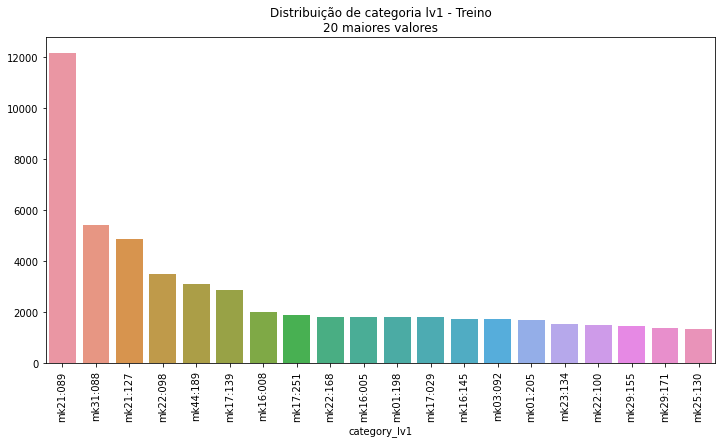

In [ ]:
plt.figure(figsize = (12, 6))
plt.xticks(rotation = 90)
plt.title('Distribuição de categoria lv1 - Treino\n20 maiores valores')
sns.countplot(orders_product_analise_tr.category_lv1,
              order = orders_product_analise_tr.category_lv1.value_counts().iloc[:20].index)
plt.ylabel('')



*   Categoria lv2



Text(0, 0.5, '')

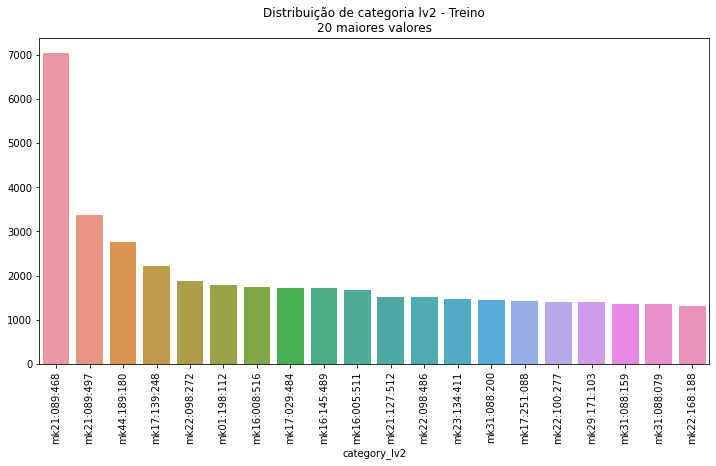

In [ ]:
plt.figure(figsize = (12, 6))
plt.xticks(rotation = 90)
plt.title('Distribuição de categoria lv2 - Treino\n20 maiores valores')
sns.countplot(orders_product_analise_tr.category_lv2,
              order = orders_product_analise_tr.category_lv2.value_counts().iloc[:20].index)
plt.ylabel('')



*   Categoria lv3



Text(0, 0.5, '')

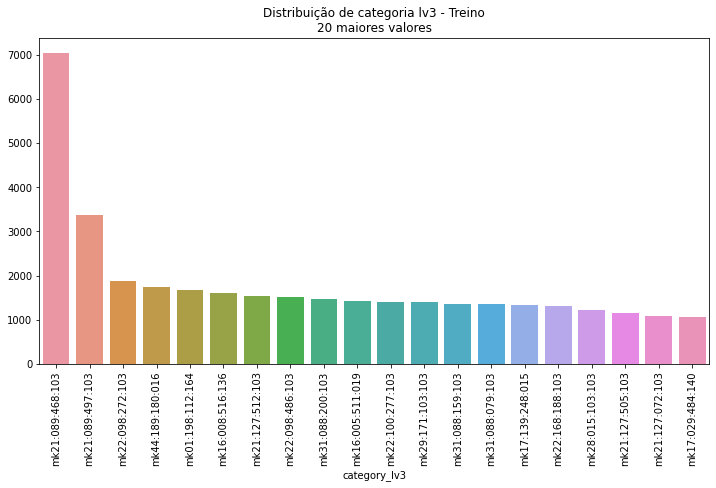

In [ ]:
plt.figure(figsize = (12, 6))
plt.xticks(rotation = 90)
plt.title('Distribuição de categoria lv3 - Treino\n20 maiores valores')
sns.countplot(orders_product_analise_tr.category_lv3,
              order = orders_product_analise_tr.category_lv3.value_counts().iloc[:20].index)
plt.ylabel('')

Text(0, 0.5, '')

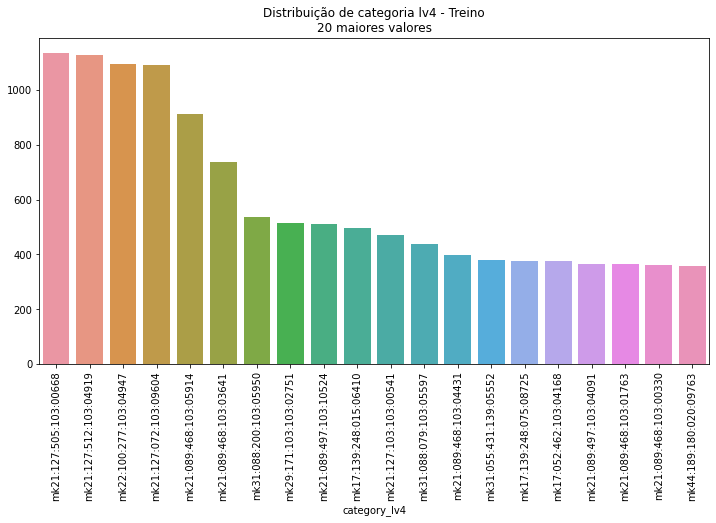

In [ ]:
plt.figure(figsize = (12, 6))
plt.xticks(rotation = 90)
plt.title('Distribuição de categoria lv4 - Treino\n20 maiores valores')
sns.countplot(orders_product_analise_tr.category_lv4,
              order = orders_product_analise_tr.category_lv4.value_counts().iloc[:20].index)
plt.ylabel('')

##### Product ID - Treino CHURN vs não CHURN

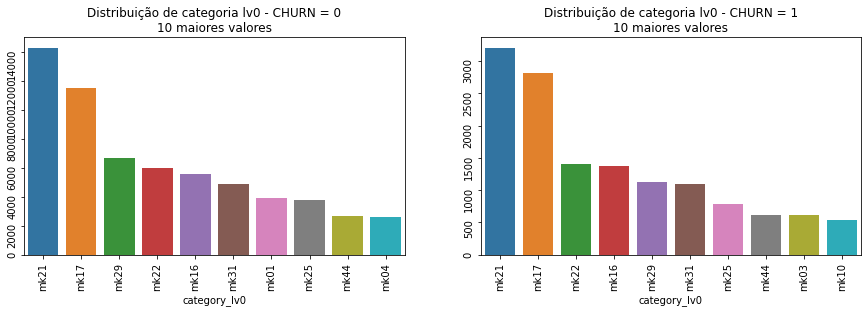

In [ ]:
fig, axs= plt.subplots(1,2, figsize = (15,4))

# churn 0 e lv0
ax0 = sns.countplot(orders_product_analise_tr_churn0.category_lv0,
                    order = orders_product_analise_tr_churn0.category_lv0.value_counts().iloc[:10].index,
                    ax=axs[0])
ax0.set_title('Distribuição de categoria lv0 - CHURN = 0\n10 maiores valores')
ax0.set_ylabel('')
ax0.tick_params(rotation = 90)

# ---------------------------------------------------------------------------------------------------------

# churn 1 e lv0
ax1 = sns.countplot(orders_product_analise_tr_churn1.category_lv0,
                    order = orders_product_analise_tr_churn1.category_lv0.value_counts().iloc[:10].index,
                    ax=axs[1])
ax1.set_title('Distribuição de categoria lv0 - CHURN = 1\n10 maiores valores')
ax1.set_ylabel('')
ax1.tick_params(rotation = 90)

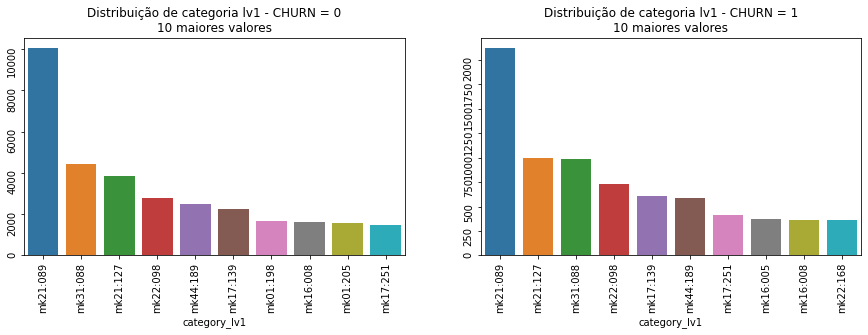

In [ ]:
fig, axs= plt.subplots(1,2, figsize = (15,4))

# churn 0 e lv1
ax2 = sns.countplot(orders_product_analise_tr_churn0.category_lv1,
                    order = orders_product_analise_tr_churn0.category_lv1.value_counts().iloc[:10].index,
                    ax=axs[0])
ax2.set_title('Distribuição de categoria lv1 - CHURN = 0\n10 maiores valores')
ax2.set_ylabel('')
ax2.tick_params(rotation = 90)

# ---------------------------------------------------------------------------------------------------------

# churn 1 e lv1
ax3 = sns.countplot(orders_product_analise_tr_churn1.category_lv1,
                    order = orders_product_analise_tr_churn1.category_lv1.value_counts().iloc[:10].index,
                    ax=axs[1])
ax3.set_title('Distribuição de categoria lv1 - CHURN = 1\n10 maiores valores')
ax3.set_ylabel('')
ax3.tick_params(rotation = 90)

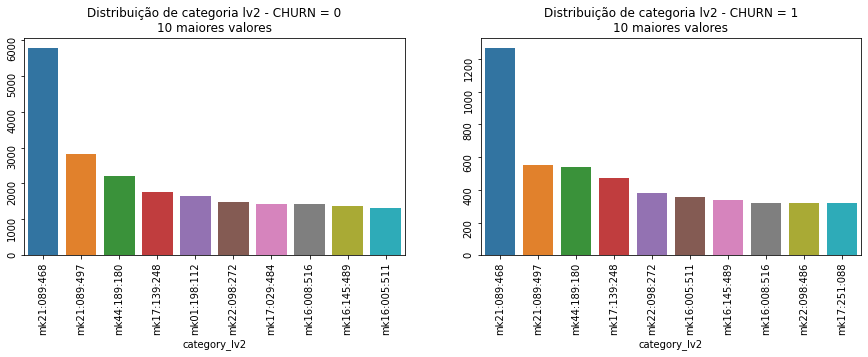

In [ ]:
fig, axs= plt.subplots(1,2, figsize = (15,4))

# churn 0 e lv2
ax4 = sns.countplot(orders_product_analise_tr_churn0.category_lv2,
                    order = orders_product_analise_tr_churn0.category_lv2.value_counts().iloc[:10].index,
                    ax=axs[0])
ax4.set_title('Distribuição de categoria lv2 - CHURN = 0\n10 maiores valores')
ax4.set_ylabel('')
ax4.tick_params(rotation = 90)

# ---------------------------------------------------------------------------------------------------------

# churn 1 e lv2
ax5 = sns.countplot(orders_product_analise_tr_churn1.category_lv2,
                    order = orders_product_analise_tr_churn1.category_lv2.value_counts().iloc[:10].index,
                    ax=axs[1])
ax5.set_title('Distribuição de categoria lv2 - CHURN = 1\n10 maiores valores')
ax5.set_ylabel('')
ax5.tick_params(rotation = 90)

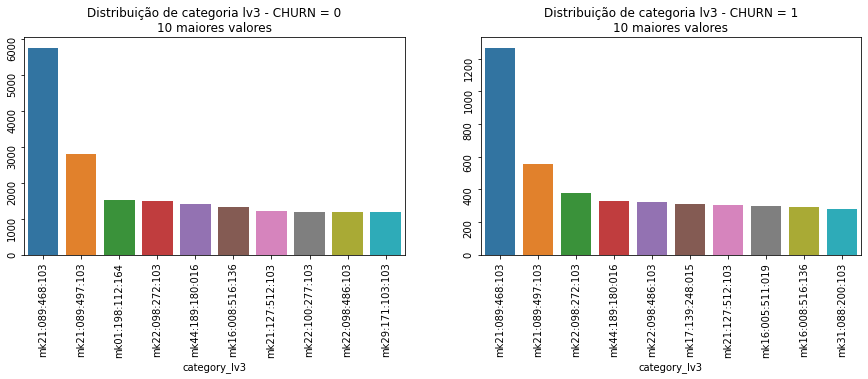

In [ ]:
fig, axs= plt.subplots(1,2, figsize = (15,4))

# churn 0 e lv3
ax6 = sns.countplot(orders_product_analise_tr_churn0.category_lv3,
                    order = orders_product_analise_tr_churn0.category_lv3.value_counts().iloc[:10].index,
                    ax=axs[0])
ax6.set_title('Distribuição de categoria lv3 - CHURN = 0\n10 maiores valores')
ax6.set_ylabel('')
ax6.tick_params(rotation = 90)

# ---------------------------------------------------------------------------------------------------------

# churn 1 e lv3
ax7 = sns.countplot(orders_product_analise_tr_churn1.category_lv3,
                    order = orders_product_analise_tr_churn1.category_lv3.value_counts().iloc[:10].index,
                    ax=axs[1])
ax7.set_title('Distribuição de categoria lv3 - CHURN = 1\n10 maiores valores')
ax7.set_ylabel('')
ax7.tick_params(rotation = 90)

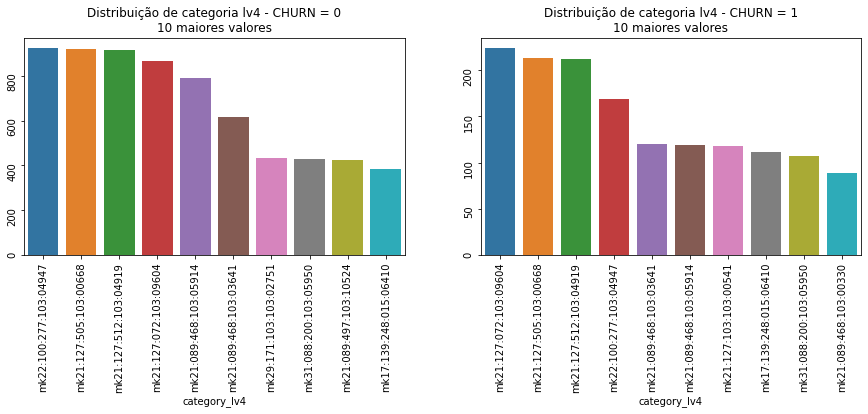

In [ ]:
fig, axs= plt.subplots(1,2, figsize = (15,4))

# churn 0 e lv4
ax8 = sns.countplot(orders_product_analise_tr_churn0.category_lv4,
                    order = orders_product_analise_tr_churn0.category_lv4.value_counts().iloc[:10].index,
                    ax=axs[0])
ax8.set_title('Distribuição de categoria lv4 - CHURN = 0\n10 maiores valores')
ax8.set_ylabel('')
ax8.tick_params(rotation = 90)

# ---------------------------------------------------------------------------------------------------------

# churn 1 e lv4
ax9 = sns.countplot(orders_product_analise_tr_churn1.category_lv4,
                    order = orders_product_analise_tr_churn1.category_lv4.value_counts().iloc[:10].index,
                    ax=axs[1])
ax9.set_title('Distribuição de categoria lv4 - CHURN = 1\n10 maiores valores')
ax9.set_ylabel('')
ax9.tick_params(rotation = 90)

#### Datetime

In [ ]:
print('data mínima:', orders_product_analise_tr.datetime.min())
print('data máxima:', orders_product_analise_tr.datetime.max())

data mínima: 2019-01-01 01:22:00
data máxima: 2019-12-31 23:34:00


Como será a distribuição de vendas durante o ano?

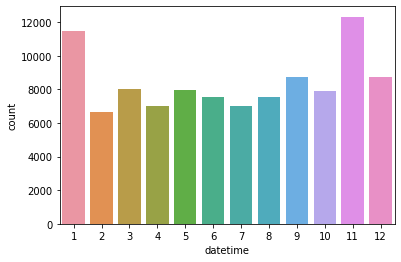

In [ ]:
sns.countplot(orders_product_analise_tr.datetime.dt.month)

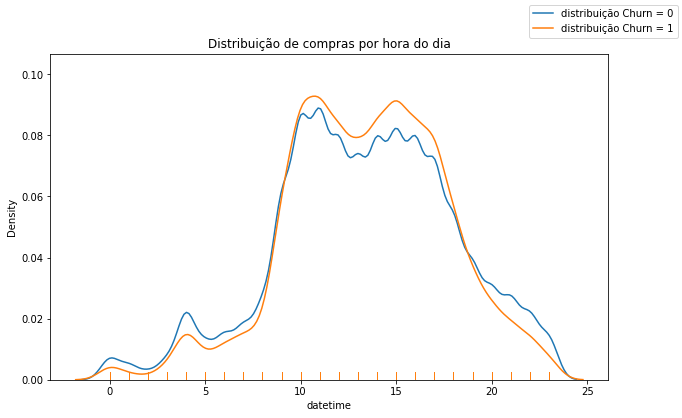

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(orders_product_analise_tr_churn0.datetime.dt.hour,
             hist=False,
             rug=True)
sns.distplot(orders_product_analise_tr_churn1.datetime.dt.hour,
             hist=False,
             rug=True)
fig.legend(labels=['distribuição Churn = 0','distribuição Churn = 1'])
plt.title('Distribuição de compras por hora do dia')
plt.show()

In [ ]:
orders_product_analise_tr

,order_id,client_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
0,ox008433,cx05072,px04611,2019-10-07 15:20:00,1.00000,49.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
2,ox076724,cx09976,px04611,2019-07-31 16:06:00,1.00000,49.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
4,ox089080,cx03223,px04611,2019-01-18 12:43:00,1.00000,49.89,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
6,ox000246,cx38788,px04611,2019-06-21 11:22:00,1.00000,49.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
8,ox040114,cx00593,px04611,2019-07-01 18:22:00,1.00000,49.90,pm05,NaN,NaN,st07,dv9,sc08,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168465,ox119488,cx33764,px04922,2019-01-09 18:38:00,1.00000,165.84,pm05,NaN,NaN,st07,dv9,sc08,mk13,mk13:280,mk13:280:260,mk13:280:260:103,mk13:280:260:103:10627
168466,ox119488,cx33764,px04922,2019-01-09 18:29:00,0.16184,-165.84,pm05,NaN,NaN,st07,dv9,sc08,mk13,mk13:280,mk13:280:260,mk13:280:260:103,mk13:280:260:103:10627
168467,ox119488,cx33764,px04922,2019-01-09 18:59:00,0.83816,-165.84,pm05,NaN,NaN,st07,dv9,sc08,mk13,mk13:280,mk13:280:260,mk13:280:260:103,mk13:280:260:103:10627
168468,ox040347,cx17160,px10881,2019-03-28 12:20:00,1.00000,99.00,pm05,NaN,12.0,st22,dv3,sc12,mk04,mk04:218,mk04:218:096,mk04:218:096:103,mk04:218:096:103:09998


#### Units

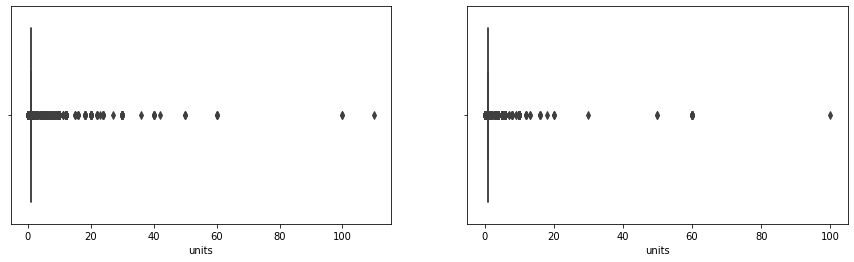

In [ ]:
fig, axs= plt.subplots(1,2, figsize = (15,4))

ax1 = sns.boxplot(orders_product_analise_tr_churn0.units,
                  ax = axs[0])
ax2 = sns.boxplot(orders_product_analise_tr_churn1.units,
                  ax = axs[1])

In [ ]:
#calculando porcentagem de outliers para dataset de churn=0
outliers(orders_product_analise_tr_churn0, 'units')

outliers superiores: 9.8 %
outliers inferiores: 2.72 %


(None, None)

In [ ]:
#calculando porcentagem de outliers para dataset de churn=1
outliers(orders_product_analise_tr_churn1, 'units')

outliers superiores: 7.11 %
outliers inferiores: 3.48 %


(None, None)

#### Price

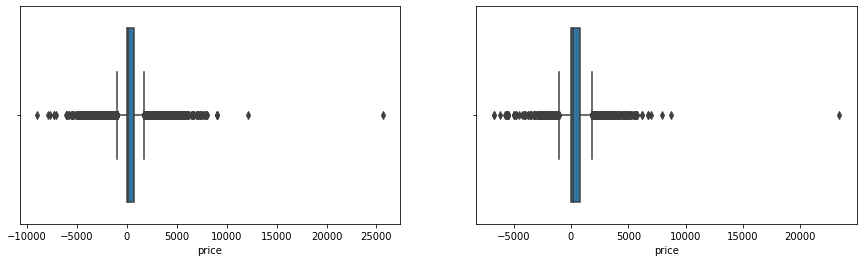

In [ ]:
fig, axs= plt.subplots(1,2, figsize = (15,4))

ax1 = sns.boxplot(orders_product_analise_tr_churn0.price,
                  ax = axs[0])
ax2 = sns.boxplot(orders_product_analise_tr_churn1.price,
                  ax = axs[1])

In [ ]:
# outliers de preço - churn = 0
outliers(orders_product_analise_tr_churn0,'price')

outliers superiores: 11.12 %
outliers inferiores: 2.45 %


(None, None)

In [ ]:
# outliers de preço - churn = 1
outliers(orders_product_analise_tr_churn1,'price')

outliers superiores: 10.65 %
outliers inferiores: 3.34 %


(None, None)

Para os dois datasets, há muitos outliers, tanto superioes quanto inferiores.

Além disso, há valores negativos de preço, que devem ser analisados

#### Método de PAgamento

In [ ]:
orders_product_analise_tr.payment_method.value_counts()

pm05    79014
pm02     8571
pm14     4214
pm10     3161
pm09     1935
pm03     1519
pm06     1043
pm13      672
pm04      522
pm12      146
pm01      136
pm07       49
pm08       15
pm11        8
Name: payment_method, dtype: int64

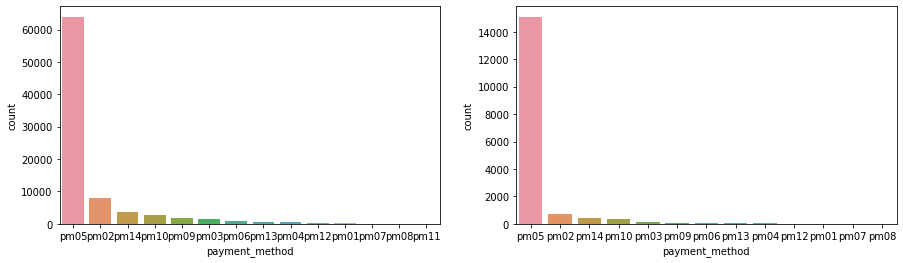

In [ ]:
fig, axs= plt.subplots(1,2, figsize = (15,4))
ax1 = sns.countplot(orders_product_analise_tr_churn0.payment_method,
                    order = orders_product_analise_tr_churn0.payment_method.value_counts().index,
                    ax = axs[0])
ax2 = sns.countplot(orders_product_analise_tr_churn1.payment_method,
                    order = orders_product_analise_tr_churn1.payment_method.value_counts().index,
                    ax = axs[1])

#### Número de parcelas

Como na documentação diz que a feature installments nula significa N/A, vou preencher os vazios com 0

In [ ]:
orders_product_analise_tr.installments.fillna(0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


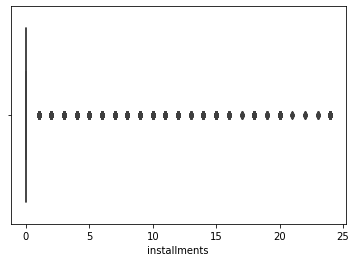

In [ ]:
sns.boxplot(orders_product_analise_tr.installments)

In [ ]:
orders_product_analise_tr_churn0.installments.fillna(0, inplace=True)
orders_product_analise_tr_churn1.installments.fillna(0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


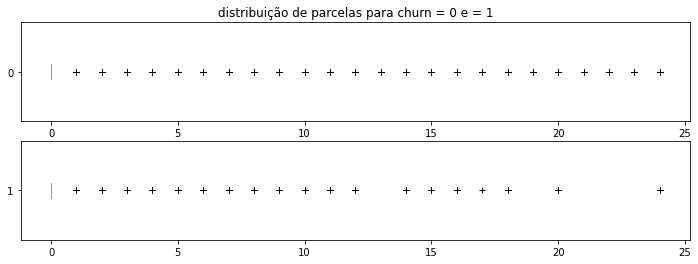

In [ ]:
# distribuição de parcelas para churn = 0 e = 1

fig = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 

ax0 = plt.subplot(gs[0])
ax0.boxplot(orders_product_analise_tr_churn0.installments,
            vert=False,
            sym = '+',
            )
ax0.set_yticklabels(['0'])
ax0.set_title("distribuição de parcelas para churn = 0 e = 1")

ax1 = plt.subplot(gs[1])
ax1.boxplot(orders_product_analise_tr_churn1.installments,
            vert=False,
            sym = '+',
            )
ax1.set_yticklabels(['1'])

fig.show()

In [ ]:
# verificando % de outliers churn 0
outliers(orders_product_analise_tr_churn0, 'installments')

outliers superiores: 23.85 %
outliers inferiores: 0.0 %


(None, None)

In [ ]:
# verificando % de outliers churn 1
outliers(orders_product_analise_tr_churn1, 'installments')

outliers superiores: 11.53 %
outliers inferiores: 0.0 %


(None, None)

#### PRazo entrega

In [ ]:
orders_product_analise_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101005 entries, 0 to 168471
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   order_id        101005 non-null  object        
 1   client_id       101005 non-null  object        
 2   product_id      101005 non-null  object        
 3   datetime        101005 non-null  datetime64[ns]
 4   units           101005 non-null  float64       
 5   price           101005 non-null  float64       
 6   payment_method  101005 non-null  object        
 7   installments    101005 non-null  float64       
 8   delivery_days   53813 non-null   float64       
 9   delivery_state  101005 non-null  object        
 10  device          101005 non-null  object        
 11  source          101005 non-null  object        
 12  category_lv0    101005 non-null  object        
 13  category_lv1    101005 non-null  object        
 14  category_lv2    101005 non-null  obj

o prazo de entrega possui muitos dados faltantes.

Essa falta de dados é relevante?

O que podemos tirar de informação desses dados?

Primeiro vamos observar como é a relação do prazo de entrega com os churns

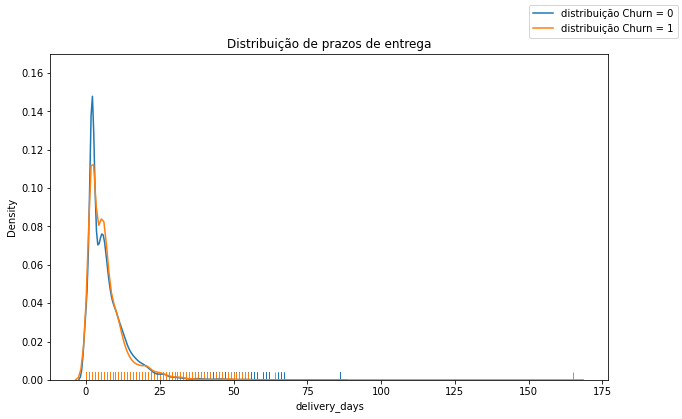

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(orders_product_analise_tr_churn0.delivery_days,
             hist=False,
             rug=True)
sns.distplot(orders_product_analise_tr_churn1.delivery_days,
             hist=False,
             rug=True)
fig.legend(labels=['distribuição Churn = 0','distribuição Churn = 1'])
plt.title('Distribuição de prazos de entrega')
plt.show()

Para churn 0 e churn 1, o prazo de entrega parece ter o mesmo efeito.

Vamos analisar se a falta de prazo significa algo.
PAra isso, vou criar uma nova feature, na qual se delivery_days == NAN, valor 0. Caso contrário, valor 1

In [ ]:
# criando uma feature com valores iguais a 1
orders_product_analise_tr['delivery_days_categ'] = 1
orders_product_analise_tr_churn0['delivery_days_categ'] = 1
orders_product_analise_tr_churn1['delivery_days_categ'] = 1

# setando 0 se valor nan, 1 caso contrário
orders_product_analise_tr.loc[orders_product_analise_tr['delivery_days'].isnull() == True, 'delivery_days_categ'] = 0
orders_product_analise_tr_churn0.loc[orders_product_analise_tr_churn0['delivery_days'].isnull() == True, 'delivery_days_categ'] = 0
orders_product_analise_tr_churn1.loc[orders_product_analise_tr_churn1['delivery_days'].isnull() == True, 'delivery_days_categ'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

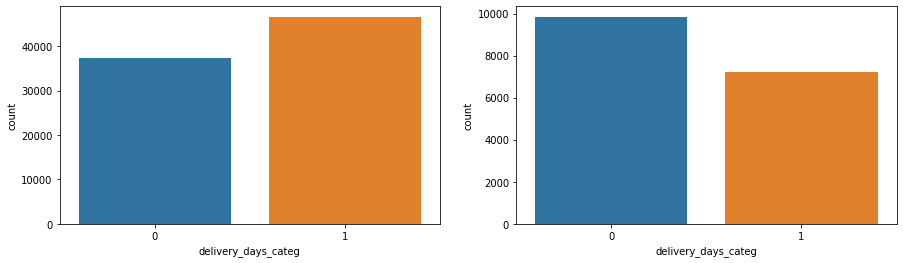

In [ ]:
fig, axs= plt.subplots(1,2, figsize = (15,4))

ax1 = sns.countplot(orders_product_analise_tr_churn0.delivery_days_categ,
                    ax=axs[0],
                    )
ax2 = sns.countplot(orders_product_analise_tr_churn1.delivery_days_categ,
                    ax=axs[1],
                    )

Parece haver uma inversão aqui.
A feature criada parece ter um papel importante no churn de clientes

#### Estado de entrega

In [ ]:
# verificando valores de estado únicos para cada cliente
orders_product_analise_tr_churn0.groupby('client_id')['delivery_state'].unique()

client_id
cx00002    [st07]
cx00004    [st01]
cx00008    [st07]
cx00009    [st07]
cx00010    [st15]
            ...  
cx38803    [st07]
cx38807    [st07]
cx38808    [st07]
cx38814    [st07]
cx38817    [st07]
Name: delivery_state, Length: 19085, dtype: object

In [ ]:
df_churn0_states = pd.DataFrame({'client_id': orders_product_analise_tr_churn0.groupby('client_id')['delivery_state'].unique().index,
      'delivery_states': orders_product_analise_tr_churn0.groupby('client_id')['delivery_state'].unique()})
df_churn0_states

,client_id,delivery_states
client_id,,
cx00002,cx00002,[st07]
cx00004,cx00004,[st01]
cx00008,cx00008,[st07]
cx00009,cx00009,[st07]
cx00010,cx00010,[st15]
...,...,...
cx38803,cx38803,[st07]
cx38807,cx38807,[st07]
cx38808,cx38808,[st07]


In [ ]:
# loop para contar diferentes valores para cada linha da
# coluna delivery_states de df_churn0_states
n_diff = []
for i in df_churn0_states['delivery_states']:
  n_diff.append(len(i))

In [ ]:
# criando nova coluna, com numero de estados diferentes
df_churn0_states['n_diff_states'] = n_diff
df_churn0_states

,client_id,delivery_states,n_diff_states
client_id,,,
cx00002,cx00002,[st07],1
cx00004,cx00004,[st01],1
cx00008,cx00008,[st07],1
cx00009,cx00009,[st07],1
cx00010,cx00010,[st15],1
...,...,...,...
cx38803,cx38803,[st07],1
cx38807,cx38807,[st07],1
cx38808,cx38808,[st07],1


{'boxes': [<matplotlib.lines.Line2D at 0x7ff20f5f3dd0>],
 'caps': [<matplotlib.lines.Line2D at 0x7ff20f4ec390>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff20f635e90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ff20f635450>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7ff20f5f33d0>,
  <matplotlib.lines.Line2D at 0x7ff20f5f35d0>]}

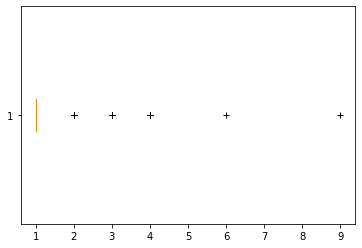

In [ ]:
plt.boxplot(df_churn0_states.n_diff_states,
            vert=False,
            sym = '+',
            )

Agora, fazendo o mesmo para churn1

{'boxes': [<matplotlib.lines.Line2D at 0x7ff20f57f910>],
 'caps': [<matplotlib.lines.Line2D at 0x7ff20f58bf90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff20fcfe390>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ff20fcfe0d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7ff20f57fb50>,
  <matplotlib.lines.Line2D at 0x7ff20f58b7d0>]}

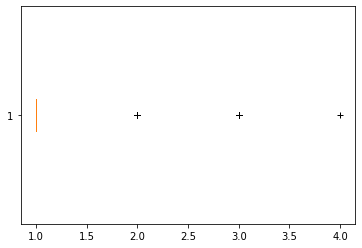

In [ ]:
df_churn1_states = pd.DataFrame({'client_id': orders_product_analise_tr_churn1.groupby('client_id')['delivery_state'].unique().index,
      'delivery_states': orders_product_analise_tr_churn1.groupby('client_id')['delivery_state'].unique()})

n_diff = []
for i in df_churn1_states['delivery_states']:
  n_diff.append(len(i))

df_churn1_states['n_diff_states'] = n_diff

plt.boxplot(df_churn1_states.n_diff_states,
            vert=False,
            sym = '+',
           )

In [ ]:
df_churn1_states.index = range(4207)
df_churn0_states.index = range(19085)
df_states = pd.concat([df_churn0_states,df_churn1_states])

In [ ]:
df_states.index = range(23292)

In [ ]:
df_states

,client_id,delivery_states,n_diff_states
0,cx00002,[st07],1
1,cx00004,[st01],1
2,cx00008,[st07],1
3,cx00009,[st07],1
4,cx00010,[st15],1
...,...,...,...
23287,cx38793,[st16],1
23288,cx38795,"[st07, st21]",2
23289,cx38796,[st07],1
23290,cx38804,[st07],1


In [ ]:
clients_tr_analise.reset_index(inplace=True)

In [ ]:
clients_tr_analise

,client_id,birthdate,state,gender,is_churn
0,cx05072,1972-03-22,st25,cg2,0
1,cx03836,1966-08-14,st15,cg1,0
2,cx08472,1954-08-07,st15,cg1,0
3,cx12946,1955-11-16,st15,cg1,0
4,cx19045,1958-10-25,st15,cg2,0
...,...,...,...,...,...
23287,cx05312,1981-08-29,st18,cg1,0
23288,cx02434,1997-03-15,st04,cg2,0
23289,cx16024,1950-10-09,st11,cg1,0
23290,cx11285,1976-07-03,st11,cg2,0


In [ ]:
df_states_tr_analise = clients_tr_analise.merge(df_states, how='inner', on='client_id')

In [ ]:
df_states_tr_analise

,client_id,birthdate,state,gender,is_churn,delivery_states,n_diff_states
0,cx05072,1972-03-22,st25,cg2,0,[st07],1
1,cx03836,1966-08-14,st15,cg1,0,[st07],1
2,cx08472,1954-08-07,st15,cg1,0,[st07],1
3,cx12946,1955-11-16,st15,cg1,0,[st07],1
4,cx19045,1958-10-25,st15,cg2,0,"[st07, st15]",2
...,...,...,...,...,...,...,...
23287,cx05312,1981-08-29,st18,cg1,0,[st07],1
23288,cx02434,1997-03-15,st04,cg2,0,[st08],1
23289,cx16024,1950-10-09,st11,cg1,0,[st07],1
23290,cx11285,1976-07-03,st11,cg2,0,"[st07, st11]",2


Agora, vamos analisar quem enviou para outros estados. Há duas situações:
 - pessoas que enviaram para mais de 1 estado diferente
 - pessoas que enviaram para outro estado, que não seja o seu de origem.

Assim, vamos primeiro criar uma nova feature, que indica 0 ou 1, se a pessoa não enviou ou enviou para outro estado.

Vamos criar e setar tudo igual a 1 (enviou). Depois, vamos inputar valor 0, se os valores da coluna 'delivery_states' for igual a 'state'.

In [ ]:
df_states_tr_analise['diff_state'] = 1

In [ ]:
df_states_tr_analise

,client_id,birthdate,state,gender,is_churn,delivery_states,n_diff_states,diff_state
0,cx05072,1972-03-22,st25,cg2,0,[st07],1,1
1,cx03836,1966-08-14,st15,cg1,0,[st07],1,1
2,cx08472,1954-08-07,st15,cg1,0,[st07],1,1
3,cx12946,1955-11-16,st15,cg1,0,[st07],1,1
4,cx19045,1958-10-25,st15,cg2,0,"[st07, st15]",2,1
...,...,...,...,...,...,...,...,...
23287,cx05312,1981-08-29,st18,cg1,0,[st07],1,1
23288,cx02434,1997-03-15,st04,cg2,0,[st08],1,1
23289,cx16024,1950-10-09,st11,cg1,0,[st07],1,1
23290,cx11285,1976-07-03,st11,cg2,0,"[st07, st11]",2,1


In [ ]:
len(df_states_tr_analise.index)

23292

In [ ]:
for i in range(len(df_states_tr_analise.index)):
  if df_states_tr_analise['delivery_states'][i][0] == df_states_tr_analise['state'][i]:
    df_states_tr_analise['diff_state'][i] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_states_tr_analise.diff_state.value_counts()

1    14546
0     8746
Name: diff_state, dtype: int64

Pelos dados do nosso dataset de treinamento, observamos que 14546 pessoas enviaram produtos para outros estados, pelo menos uma vez. Enquanto 8746 enviaram somente para o mesmo estado de origem

Vamos avaliar se existe relação entre essa nova feature e churn mais para frente

#### Device

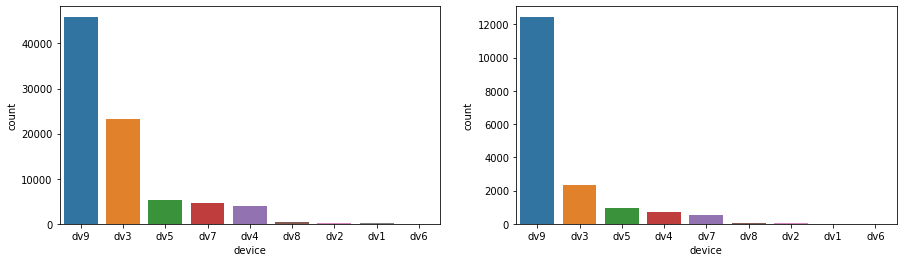

In [ ]:
fig, axs= plt.subplots(1,2, figsize = (15,4))

axs1 = sns.countplot(orders_product_analise_tr_churn0.device,
                     order = orders_product_analise_tr_churn0.device.value_counts().index,
                     ax = axs[0])

axs2 = sns.countplot(orders_product_analise_tr_churn1.device,
                     order = orders_product_analise_tr_churn1.device.value_counts().index,
                     ax = axs[1])

Proporcionalmente, o dispositivo dv9 parece mais utilizado quando há churn

#### Source

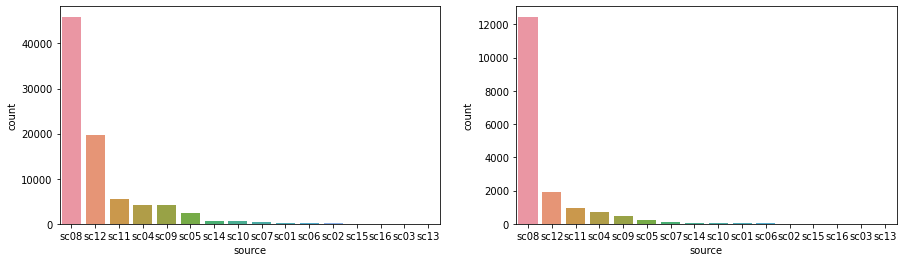

In [ ]:
fig, axs= plt.subplots(1,2, figsize = (15,4))

axs1 = sns.countplot(orders_product_analise_tr_churn0.source,
                     order = orders_product_analise_tr_churn0.source.value_counts().index,
                     ax = axs[0])

axs2 = sns.countplot(orders_product_analise_tr_churn1.source,
                     order = orders_product_analise_tr_churn1.source.value_counts().index,
                     ax = axs[1])

Novamente, de forma proporcional, quando há churn, a fonte sc08 é maior

## Limpeza & Pré-Processamento

Depois de explorar os dados brutos, é importante entender se já existem dados _outliers_ ou errados que corrompem ou invalidam certos registros (linhas da tabela) e que deveriam 1) serem tratados de alguma forma ou 2) eliminados do dataset. Se essa necessidade não surgiu com a EDA, das duas uma: ou não há realmente nada a fazer, ou é necessário explorar mais os dados pra entendê-los.

In [ ]:
''' Espaço reservado para a Solução '''

' Espaço reservado para a Solução '

## *Feature Engineering*

Essa é a etapa que pode dar mais trabalho, devido ao formato de eventos da **tabela de vendas**. Para facilitar um pouco, será dada a seguir uma sugestão de _feature engineering_. Caso haja uma vontade de incluir mais _features_, basta editar o código a seguir.


### Funções Auxiliares

Funções para ajudar nas diferentes ĩdéias de _feature engineering_.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [ ]:
class OrderAggregatorFeaturesTransform(BaseEstimator, TransformerMixin):
    """ Classe base para FeaturesTransformers que usam os dados de Histórico de Vendas para extrair os dados.
    """
    
    def __init__(self, orders_table, columns=None, product_table=None, imputer=None):
        
        self.work_table = None
        if product_table is not None:
            self.refr_table = pd.merge(
                orders_table,
                product_table.reset_index(),
                on='product_id'
            )
        else:
            self.refr_table = orders_table.copy()
        if columns is not None:
            self.refr_table = self.refr_table[['client_id', *columns]]
        self._reset_database()
        self.imputer = imputer
        self.columns = columns

    def _reset_database(self):
        self.work_table = self.refr_table.copy()
        return self

    def _process_client(self, df):
        return df.set_index('client_id')

    def _select_orders(self, df):
        idx = self.work_table['client_id'].isin(df.index)
        return self.work_table[idx]

    def fit(self, X, y=None, **fit_params):
        if self.imputer is not None:
            self._reset_database()
            self.imputer.fit(self._select_orders(X)[self.columns])
            self.work_table.loc[:, self.columns] = self.imputer.transform(self.work_table[self.columns])
        return self
    
    def transform(self, X):
        return self._select_orders(X).groupby('client_id').apply(self._process_client)

In [ ]:
class UniqueCounterTransform(OrderAggregatorFeaturesTransform):

    def _process_client(self, df):
        tmp = super()._process_client(df)
        return tmp.apply(lambda x: len(x.unique())).rename(index=lambda x: f'count_{x}')

In [ ]:
class SumValuesTransform(OrderAggregatorFeaturesTransform):

    def _process_client(self, df):
        tmp = super()._process_client(df)
        return tmp.sum().rename(index=lambda x: f'sum_{x}')

In [ ]:
class DistributionTransform(OrderAggregatorFeaturesTransform):

    def _process_client(self, df):
        tmp = (super()
               ._process_client(df)
               .describe()
               .drop(index='count')
               .rename(index=lambda c: c.replace('%', 'p')) 
               .rename(index={'mean': 'avg'})
               .unstack())
        tmp.index = tmp.index.map('_'.join)
        return tmp

In [ ]:
class CountStateMatchesTransform(OrderAggregatorFeaturesTransform):
    
    def _process_client(self, df):
        tmp = df.set_index('client_id')[['state', 'delivery_state']]
        return pd.Series({
            'count_orders_states_eq': (tmp.state == tmp.delivery_state).sum(),
            'count_orders_states_ne': (tmp.state != tmp.delivery_state).sum()
        })

    def transform(self, X):
        return (
            pd.merge(
                self._select_orders(X),
                X[['state']].reset_index(),
                on='client_id'
            ).groupby('client_id').apply(self._process_client)
        )

### Sugestão de Feature Engineering		

Algumas features interessantes para serem extraidas dos dados, por cliente, estão mostradas a seguir.

- `gender_g1`: __bool_ calculada a partir do `gender`
- `client_age`: calculada a partir do `birthdate`

- `sum_units`: total de itens comprados em 2019
- `sum_volume`: total gasto em compras em 2019

- `count_orders_states_ne`: quantidade de compras entregando em estados diferentes ao do cliente
- `count_orders_states_eq`: quantidade de compras entregando em estados iguais ao do cliente

- `count_product_id`: quantidade de produtos diferentes presentes nas compras
- `count_device`: quantidade de produtos diferentes presentes nas compras
- `count_source`: quantidade de produtos diferentes presentes nas compras
- `count_payment_method`: quantidade de meios de pagamento em compras

- `count_category_lv0`: quantidade de categorias diferentes (nível 0) em compras
- `count_category_lv1`: quantidade de categorias diferentes (nível 1) em compras
- `count_category_lv2`: quantidade de categorias diferentes (nível 2) em compras
- `count_category_lv3`: quantidade de categorias diferentes (nível 3) em compras
- `count_category_lv4`: quantidade de categorias diferentes (nível 4) em compras

- `price_avg`: média dos preços pagos em cada item comprado
- `price_std`: desvio padrão dos preços pagos em cada item comprado
- `price_min`: mínimo dos preços pagos em cada item comprado
- `price_25p`: quartil 25% dos preços pagos em cada item comprado
- `price_50p`: quartil 50% dos preços pagos em cada item comprado
- `price_75p`: quartil 75% dos preços pagos em cada item comprado
- `price_max`: máximo dos preços pagos em cada item comprado

- `delivery_days_avg`: média da quantidade de dias para entregar (prazo)
- `delivery_days_std`: desvio padrão da quantidade de dias para entregar (prazo)
- `delivery_days_min`: mínimo da quantidade de dias para entregar (prazo)
- `delivery_days_25p`: quartil 25% da quantidade de dias para entregar (prazo)
- `delivery_days_50p`: quartil 50% da quantidade de dias para entregar (prazo)
- `delivery_days_75p`: quartil 75% da quantidade de dias para entregar (prazo)
- `delivery_days_max`: máximo da quantidade de dias para entregar (prazo)

- `installments_avg`: média da quantidade de parcelas de pagamento
- `installments_std`: desvio padrão da quantidade de parcelas de pagamento
- `installments_min`: mínimo da quantidade de parcelas de pagamento
- `installments_25p`: quartil 25% da quantidade de parcelas de pagamento
- `installments_50p`: quartil 50% da quantidade de parcelas de pagamento
- `installments_75p`: quartil 75% da quantidade de parcelas de pagamento
- `installments_max`: máximo da quantidade de parcelas de pagamento

In [ ]:
class FeatureEngineeringTransform(BaseEstimator, TransformerMixin):

    def __init__(self, orders_table, product_table):
        orders_table['volume'] = orders_table.units * orders_table.price
        self._transf_sum = SumValuesTransform(orders_table=orders_table, columns=['units', 'volume'])
        self._transf_stt = CountStateMatchesTransform(orders_table=orders_table[['client_id', 'delivery_state']])
        self._transf_cnt = UniqueCounterTransform(
            orders_table=orders_table, 
            product_table=product, 
            columns=['product_id', 'device', 'source', 'payment_method', 
                     'category_lv0', 'category_lv1', 'category_lv2', 'category_lv3', 'category_lv4']
        )
        self._transf_dst_med = DistributionTransform(
            orders_table=orders_table, 
            product_table=product, 
            columns=['price', 'delivery_days'],
            imputer=SimpleImputer(strategy='median')
        )
        self._transf_dst_one = DistributionTransform(
            orders_table=orders_table, 
            product_table=product, 
            columns=['installments'],
            imputer=SimpleImputer(strategy='constant', fill_value=1)
        )
        
    def fit(self, X, y=None, **fit_params): 
        self._transf_dst_med.fit(X)
        self._transf_dst_one.fit(X)
        return self
    
    def transform(self, X):
        output = (X[['gender']] == 'cg1').rename(columns={'gender': 'gender_cg1'})
        output['client_age'] = 2021 - X.birthdate.dt.year
        output = output.join(self._transf_sum.transform(X))
        output = output.join(self._transf_stt.transform(X))
        output = output.join(self._transf_cnt.transform(X))
        output = output.join(self._transf_dst_med.transform(X))
        output = output.join(self._transf_dst_one.transform(X))
        return output

Deu algum erro nas funções de feature engineering fornecidas.

Como não terei tempo suficiente para solucionar tal erro, vou fazer do meu jeito.

O jeito é o seguinte.

1 - temos dois principais datasets:
 - df_states_tr_analise, que é de treino e possui os dados do cliente, assim como features criadas 'delivery_states','n_diff_states',	'diff_state'
 - orders_product_analise_tr, que corresponde às compras, somente pelos clientes da base de treino

Agora, vamos criar novas features para a df_states_tr_analise, com base na orders_product_analise_tr e depois reproduzir para os datasets de teste.

#### Idade (age)

In [ ]:
# criando a feature de idade, com base no ano de nascimento.
df_states_tr_analise['age'] = 2022 - df_states_tr_analise['birthdate'].dt.year

#### total gasto 2019

In [ ]:
tmp = pd.DataFrame({'total_spent':orders_product_analise_tr.groupby('client_id')['price'].sum()}).reset_index()

In [ ]:
df_states_tr_analise = df_states_tr_analise.merge(tmp, how = 'inner', on = 'client_id')

In [ ]:
df_states_tr_analise.total_spent.describe()

count    23292.000000
mean      1940.644345
std       2384.436848
min     -25175.890000
25%        391.440000
50%       1275.100000
75%       2701.755000
max      94936.510000
Name: total_spent, dtype: float64

In [ ]:
outliers(df_states_tr_analise, 'total_spent')

outliers superiores: 8.03 %
outliers inferiores: 0.17 %


(None, None)

#### preço máximo pago

In [ ]:
tmp = pd.DataFrame({'price_max':orders_product_analise_tr.groupby('client_id')['price'].max()}).reset_index()

In [ ]:
df_states_tr_analise = df_states_tr_analise.merge(tmp, how = 'inner', on = 'client_id')

#### Preço médio

In [ ]:
tmp = pd.DataFrame({'price_avg':orders_product_analise_tr.groupby('client_id')['price'].mean()}).reset_index()
df_states_tr_analise = df_states_tr_analise.merge(tmp, how = 'inner', on = 'client_id')

#### Parcelamento

In [ ]:
tmp = pd.DataFrame({'installments_min':orders_product_analise_tr.groupby('client_id')['installments'].min()}).reset_index()
df_states_tr_analise = df_states_tr_analise.merge(tmp, how = 'inner', on = 'client_id')

In [ ]:
tmp = pd.DataFrame({'installments_max':orders_product_analise_tr.groupby('client_id')['installments'].max()}).reset_index()
df_states_tr_analise = df_states_tr_analise.merge(tmp, how = 'inner', on = 'client_id')

In [ ]:
tmp = pd.DataFrame({'installments_avg':orders_product_analise_tr.groupby('client_id')['installments'].mean()}).reset_index()
df_states_tr_analise = df_states_tr_analise.merge(tmp, how = 'inner', on = 'client_id')

#### Produtos diferentes

In [ ]:
tmp = pd.DataFrame({'diff_products':orders_product_analise_tr.groupby('client_id')['product_id'].nunique()}).reset_index()
df_states_tr_analise = df_states_tr_analise.merge(tmp, how = 'inner', on = 'client_id')

#### Níveis produtos

In [ ]:
tmp = pd.DataFrame({'diff_cat_lv0':orders_product_analise_tr.groupby('client_id')['category_lv0'].nunique()}).reset_index()
df_states_tr_analise = df_states_tr_analise.merge(tmp, how = 'inner', on = 'client_id')

tmp = pd.DataFrame({'diff_cat_lv1':orders_product_analise_tr.groupby('client_id')['category_lv1'].nunique()}).reset_index()
df_states_tr_analise = df_states_tr_analise.merge(tmp, how = 'inner', on = 'client_id')

tmp = pd.DataFrame({'diff_cat_lv2':orders_product_analise_tr.groupby('client_id')['category_lv2'].nunique()}).reset_index()
df_states_tr_analise = df_states_tr_analise.merge(tmp, how = 'inner', on = 'client_id')

tmp = pd.DataFrame({'diff_cat_lv3':orders_product_analise_tr.groupby('client_id')['category_lv3'].nunique()}).reset_index()
df_states_tr_analise = df_states_tr_analise.merge(tmp, how = 'inner', on = 'client_id')

tmp = pd.DataFrame({'diff_cat_lv4':orders_product_analise_tr.groupby('client_id')['category_lv4'].nunique()}).reset_index()
df_states_tr_analise = df_states_tr_analise.merge(tmp, how = 'inner', on = 'client_id')

In [ ]:
df_states_tr_analise

,client_id,birthdate,state,gender,is_churn,delivery_states,n_diff_states,diff_state,age,total_spent,...,price_avg,installments_min,installments_max,installments_avg,diff_products,diff_cat_lv0,diff_cat_lv1,diff_cat_lv2,diff_cat_lv3,diff_cat_lv4
0,cx05072,1972-03-22,st25,cg2,0,[st07],1,1,50,119.80,...,59.900000,0.0,0.0,0.0,2,1,2,2,2,2
1,cx03836,1966-08-14,st15,cg1,0,[st07],1,1,56,546.76,...,78.108571,0.0,0.0,0.0,6,3,6,6,6,6
2,cx08472,1954-08-07,st15,cg1,0,[st07],1,1,68,2832.92,...,944.306667,0.0,0.0,0.0,2,2,2,2,2,2
3,cx12946,1955-11-16,st15,cg1,0,[st07],1,1,67,69.90,...,69.900000,0.0,0.0,0.0,1,1,1,1,1,1
4,cx19045,1958-10-25,st15,cg2,0,"[st07, st15]",2,1,64,734.94,...,48.996000,0.0,0.0,0.0,14,5,5,10,10,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23287,cx05312,1981-08-29,st18,cg1,0,[st07],1,1,41,879.02,...,293.006667,0.0,0.0,0.0,3,3,3,3,3,3
23288,cx02434,1997-03-15,st04,cg2,0,[st08],1,1,25,1952.90,...,1952.900000,10.0,10.0,10.0,1,1,1,1,1,1
23289,cx16024,1950-10-09,st11,cg1,0,[st07],1,1,72,978.00,...,326.000000,0.0,0.0,0.0,3,3,3,3,3,3
23290,cx11285,1976-07-03,st11,cg2,0,"[st07, st11]",2,1,46,-1630.09,...,-62.695769,0.0,0.0,0.0,10,5,6,7,7,10


Agora, podemos droppar as features que não fazem mais sentido

In [ ]:
df_states_tr_analise.columns

Index(['client_id', 'birthdate', 'state', 'gender', 'is_churn',
       'delivery_states', 'n_diff_states', 'diff_state', 'age', 'total_spent',
       'price_max', 'price_avg', 'installments_min', 'installments_max',
       'installments_avg', 'diff_products', 'diff_cat_lv0', 'diff_cat_lv1',
       'diff_cat_lv2', 'diff_cat_lv3', 'diff_cat_lv4'],
      dtype='object')

In [ ]:
df_states_tr_analise = df_states_tr_analise.drop(['client_id', 'birthdate', 'delivery_states',
                                                  'diff_cat_lv1', 'diff_cat_lv2', 'diff_cat_lv3',
                                                  'diff_cat_lv4'], axis = 1)

In [ ]:
df_states_tr_analise.columns

Index(['state', 'gender', 'is_churn', 'n_diff_states', 'diff_state', 'age',
       'total_spent', 'price_max', 'price_avg', 'installments_min',
       'installments_max', 'installments_avg', 'diff_products',
       'diff_cat_lv0'],
      dtype='object')

### Feature Engineering para TESTE

Temos as bases:
 - clients_te - base clientes teste
 - orders_product_analise - total de compras e produtos

In [ ]:
clients_te

,birthdate,state,gender,is_churn
client_id,,,,
cx06840,1982-12-03,st15,cg1,False
cx01931,1979-05-09,st15,cg1,False
cx35431,1965-05-09,st15,cg1,False
cx36233,1954-03-15,st15,cg2,False
cx13540,1965-06-19,st15,cg1,False
...,...,...,...,...
cx19119,1980-05-31,st24,cg1,False
cx21963,1984-08-25,st15,cg2,False
cx37195,1960-01-16,st13,cg2,False


In [ ]:
clients_te.reset_index(inplace=True)

In [ ]:
clients_te.duplicated().sum()

0

In [ ]:
df_test_states = pd.DataFrame({'client_id': orders_product_analise.groupby('client_id')['delivery_state'].unique().index,
                               'delivery_states': orders_product_analise.groupby('client_id')['delivery_state'].unique()})
df_test_states

,client_id,delivery_states
client_id,,
cx00001,cx00001,[st07]
cx00002,cx00002,[st07]
cx00003,cx00003,"[st21, st07]"
cx00004,cx00004,[st01]
cx00005,cx00005,[st07]
...,...,...
cx38817,cx38817,[st07]
cx38818,cx38818,[st22]
cx38819,cx38819,[st07]


In [ ]:
# loop para contar diferentes valores para cada linha da
# coluna delivery_states de df_test_states
n_diff = []
for i in df_test_states['delivery_states']:
  n_diff.append(len(i))

# criando nova coluna, com numero de estados diferentes
df_test_states['n_diff_states'] = n_diff

In [ ]:
df_test_states.index = range(38821)
df_test_states

,client_id,delivery_states,n_diff_states
0,cx00001,[st07],1
1,cx00002,[st07],1
2,cx00003,"[st21, st07]",2
3,cx00004,[st01],1
4,cx00005,[st07],1
...,...,...,...
38816,cx38817,[st07],1
38817,cx38818,[st22],1
38818,cx38819,[st07],1
38819,cx38820,[st15],1


In [ ]:
df_states_test_analise = clients_te.merge(df_test_states, how = 'inner', on = 'client_id')

In [ ]:
df_states_test_analise

,client_id,birthdate,state,gender,is_churn,delivery_states,n_diff_states
0,cx06840,1982-12-03,st15,cg1,False,[st07],1
1,cx01931,1979-05-09,st15,cg1,False,[st07],1
2,cx35431,1965-05-09,st15,cg1,False,[st07],1
3,cx36233,1954-03-15,st15,cg2,False,[st07],1
4,cx13540,1965-06-19,st15,cg1,False,[st07],1
...,...,...,...,...,...,...,...
7759,cx19119,1980-05-31,st24,cg1,False,[st07],1
7760,cx21963,1984-08-25,st15,cg2,False,[st07],1
7761,cx37195,1960-01-16,st13,cg2,False,[st07],1
7762,cx16851,2000-04-27,st25,cg2,False,[st25],1


In [ ]:
df_states_test_analise['diff_state'] = 1
for i in range(len(df_states_test_analise.index)):
  if df_states_test_analise['delivery_states'][i][0] == df_states_test_analise['state'][i]:
    df_states_test_analise['diff_state'][i] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df_states_test_analise

,client_id,birthdate,state,gender,is_churn,delivery_states,n_diff_states,diff_state
0,cx06840,1982-12-03,st15,cg1,False,[st07],1,1
1,cx01931,1979-05-09,st15,cg1,False,[st07],1,1
2,cx35431,1965-05-09,st15,cg1,False,[st07],1,1
3,cx36233,1954-03-15,st15,cg2,False,[st07],1,1
4,cx13540,1965-06-19,st15,cg1,False,[st07],1,1
...,...,...,...,...,...,...,...,...
7759,cx19119,1980-05-31,st24,cg1,False,[st07],1,1
7760,cx21963,1984-08-25,st15,cg2,False,[st07],1,1
7761,cx37195,1960-01-16,st13,cg2,False,[st07],1,1
7762,cx16851,2000-04-27,st25,cg2,False,[st25],1,0


In [ ]:
# criando a feature de idade, com base no ano de nascimento.
df_states_test_analise['age'] = 2022 - df_states_test_analise['birthdate'].dt.year

In [ ]:
df_states_test_analise.client_id.duplicated().sum()

0

In [ ]:
# total gasto
tmp = pd.DataFrame({'total_spent':orders_product_analise.groupby('client_id')['price'].sum()}).reset_index()
df_states_test_analise = df_states_test_analise.merge(tmp, how = 'inner', on = 'client_id')

In [ ]:
df_states_test_analise

,client_id,birthdate,state,gender,is_churn,delivery_states,n_diff_states,diff_state,age,total_spent
0,cx06840,1982-12-03,st15,cg1,False,[st07],1,1,40,340.60
1,cx01931,1979-05-09,st15,cg1,False,[st07],1,1,43,204.70
2,cx35431,1965-05-09,st15,cg1,False,[st07],1,1,57,79.00
3,cx36233,1954-03-15,st15,cg2,False,[st07],1,1,68,4643.00
4,cx13540,1965-06-19,st15,cg1,False,[st07],1,1,57,183.80
...,...,...,...,...,...,...,...,...,...,...
7759,cx19119,1980-05-31,st24,cg1,False,[st07],1,1,42,799.00
7760,cx21963,1984-08-25,st15,cg2,False,[st07],1,1,38,39.00
7761,cx37195,1960-01-16,st13,cg2,False,[st07],1,1,62,110.19
7762,cx16851,2000-04-27,st25,cg2,False,[st25],1,0,22,899.00


In [ ]:
df_states_test_analise.client_id.duplicated().sum()

0

In [ ]:
# preço máximo
tmp = pd.DataFrame({'price_max':orders_product_analise.groupby('client_id')['price'].max()}).reset_index()
df_states_test_analise = df_states_test_analise.merge(tmp, how = 'inner', on = 'client_id')

In [ ]:
df_states_test_analise

,client_id,birthdate,state,gender,is_churn,delivery_states,n_diff_states,diff_state,age,total_spent,price_max
0,cx06840,1982-12-03,st15,cg1,False,[st07],1,1,40,340.60,79.90
1,cx01931,1979-05-09,st15,cg1,False,[st07],1,1,43,204.70,129.90
2,cx35431,1965-05-09,st15,cg1,False,[st07],1,1,57,79.00,79.00
3,cx36233,1954-03-15,st15,cg2,False,[st07],1,1,68,4643.00,4294.00
4,cx13540,1965-06-19,st15,cg1,False,[st07],1,1,57,183.80,59.90
...,...,...,...,...,...,...,...,...,...,...,...
7759,cx19119,1980-05-31,st24,cg1,False,[st07],1,1,42,799.00,799.00
7760,cx21963,1984-08-25,st15,cg2,False,[st07],1,1,38,39.00,39.00
7761,cx37195,1960-01-16,st13,cg2,False,[st07],1,1,62,110.19,110.19
7762,cx16851,2000-04-27,st25,cg2,False,[st25],1,0,22,899.00,899.00


In [ ]:
df_states_test_analise.client_id.duplicated().sum()

0

In [ ]:
# preço médio
tmp = pd.DataFrame({'price_avg':orders_product_analise.groupby('client_id')['price'].mean()}).reset_index()
df_states_test_analise = df_states_test_analise.merge(tmp, how = 'inner', on = 'client_id')

In [ ]:
df_states_test_analise

,client_id,birthdate,state,gender,is_churn,delivery_states,n_diff_states,diff_state,age,total_spent,price_max,price_avg
0,cx06840,1982-12-03,st15,cg1,False,[st07],1,1,40,340.60,79.90,48.657143
1,cx01931,1979-05-09,st15,cg1,False,[st07],1,1,43,204.70,129.90,68.233333
2,cx35431,1965-05-09,st15,cg1,False,[st07],1,1,57,79.00,79.00,79.000000
3,cx36233,1954-03-15,st15,cg2,False,[st07],1,1,68,4643.00,4294.00,2321.500000
4,cx13540,1965-06-19,st15,cg1,False,[st07],1,1,57,183.80,59.90,45.950000
...,...,...,...,...,...,...,...,...,...,...,...,...
7759,cx19119,1980-05-31,st24,cg1,False,[st07],1,1,42,799.00,799.00,799.000000
7760,cx21963,1984-08-25,st15,cg2,False,[st07],1,1,38,39.00,39.00,39.000000
7761,cx37195,1960-01-16,st13,cg2,False,[st07],1,1,62,110.19,110.19,110.190000
7762,cx16851,2000-04-27,st25,cg2,False,[st25],1,0,22,899.00,899.00,899.000000


In [ ]:
# Parcelamentos
tmp = pd.DataFrame({'installments_min':orders_product_analise.groupby('client_id')['installments'].min()}).reset_index()
df_states_test_analise = df_states_test_analise.merge(tmp, how = 'inner', on = 'client_id')

tmp = pd.DataFrame({'installments_max':orders_product_analise.groupby('client_id')['installments'].max()}).reset_index()
df_states_test_analise = df_states_test_analise.merge(tmp, how = 'inner', on = 'client_id')

tmp = pd.DataFrame({'installments_avg':orders_product_analise.groupby('client_id')['installments'].mean()}).reset_index()
df_states_test_analise = df_states_test_analise.merge(tmp, how = 'inner', on = 'client_id')

In [ ]:
df_states_test_analise

,client_id,birthdate,state,gender,is_churn,delivery_states,n_diff_states,diff_state,age,total_spent,price_max,price_avg,installments_min,installments_max,installments_avg
0,cx06840,1982-12-03,st15,cg1,False,[st07],1,1,40,340.60,79.90,48.657143,NaN,NaN,NaN
1,cx01931,1979-05-09,st15,cg1,False,[st07],1,1,43,204.70,129.90,68.233333,NaN,NaN,NaN
2,cx35431,1965-05-09,st15,cg1,False,[st07],1,1,57,79.00,79.00,79.000000,NaN,NaN,NaN
3,cx36233,1954-03-15,st15,cg2,False,[st07],1,1,68,4643.00,4294.00,2321.500000,NaN,NaN,NaN
4,cx13540,1965-06-19,st15,cg1,False,[st07],1,1,57,183.80,59.90,45.950000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7759,cx19119,1980-05-31,st24,cg1,False,[st07],1,1,42,799.00,799.00,799.000000,NaN,NaN,NaN
7760,cx21963,1984-08-25,st15,cg2,False,[st07],1,1,38,39.00,39.00,39.000000,NaN,NaN,NaN
7761,cx37195,1960-01-16,st13,cg2,False,[st07],1,1,62,110.19,110.19,110.190000,NaN,NaN,NaN
7762,cx16851,2000-04-27,st25,cg2,False,[st25],1,0,22,899.00,899.00,899.000000,NaN,NaN,NaN


In [ ]:
# produtos diferentes
tmp = pd.DataFrame({'diff_products':orders_product_analise.groupby('client_id')['product_id'].nunique()}).reset_index()
df_states_test_analise = df_states_test_analise.merge(tmp, how = 'inner', on = 'client_id')

In [ ]:
# nível produto 0
tmp = pd.DataFrame({'diff_cat_lv0':orders_product_analise.groupby('client_id')['category_lv0'].nunique()}).reset_index()
df_states_test_analise = df_states_test_analise.merge(tmp, how = 'inner', on = 'client_id')

In [ ]:
df_states_test_analise

,client_id,birthdate,state,gender,is_churn,delivery_states,n_diff_states,diff_state,age,total_spent,price_max,price_avg,installments_min,installments_max,installments_avg,diff_products,diff_cat_lv0
0,cx06840,1982-12-03,st15,cg1,False,[st07],1,1,40,340.60,79.90,48.657143,NaN,NaN,NaN,7,3
1,cx01931,1979-05-09,st15,cg1,False,[st07],1,1,43,204.70,129.90,68.233333,NaN,NaN,NaN,3,1
2,cx35431,1965-05-09,st15,cg1,False,[st07],1,1,57,79.00,79.00,79.000000,NaN,NaN,NaN,1,1
3,cx36233,1954-03-15,st15,cg2,False,[st07],1,1,68,4643.00,4294.00,2321.500000,NaN,NaN,NaN,2,2
4,cx13540,1965-06-19,st15,cg1,False,[st07],1,1,57,183.80,59.90,45.950000,NaN,NaN,NaN,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7759,cx19119,1980-05-31,st24,cg1,False,[st07],1,1,42,799.00,799.00,799.000000,NaN,NaN,NaN,1,1
7760,cx21963,1984-08-25,st15,cg2,False,[st07],1,1,38,39.00,39.00,39.000000,NaN,NaN,NaN,1,1
7761,cx37195,1960-01-16,st13,cg2,False,[st07],1,1,62,110.19,110.19,110.190000,NaN,NaN,NaN,1,1
7762,cx16851,2000-04-27,st25,cg2,False,[st25],1,0,22,899.00,899.00,899.000000,NaN,NaN,NaN,1,1


In [ ]:
['state', 'gender', 'is_churn', 'n_diff_states', 'diff_state', 'age',
       'total_spent', 'price_max', 'price_avg', 'installments_min',
       'installments_max', 'installments_avg', 'diff_products',
       'diff_cat_lv0']

['state',
 'gender',
 'is_churn',
 'n_diff_states',
 'diff_state',
 'age',
 'total_spent',
 'price_max',
 'price_avg',
 'installments_min',
 'installments_max',
 'installments_avg',
 'diff_products',
 'diff_cat_lv0']

In [ ]:
# removendo as features não importantes
df_states_test_analise = df_states_test_analise.drop(['client_id', 'birthdate', 'delivery_states'], axis = 1)
df_states_test_analise

,state,gender,is_churn,n_diff_states,diff_state,age,total_spent,price_max,price_avg,installments_min,installments_max,installments_avg,diff_products,diff_cat_lv0
0,st15,cg1,False,1,1,40,340.60,79.90,48.657143,NaN,NaN,NaN,7,3
1,st15,cg1,False,1,1,43,204.70,129.90,68.233333,NaN,NaN,NaN,3,1
2,st15,cg1,False,1,1,57,79.00,79.00,79.000000,NaN,NaN,NaN,1,1
3,st15,cg2,False,1,1,68,4643.00,4294.00,2321.500000,NaN,NaN,NaN,2,2
4,st15,cg1,False,1,1,57,183.80,59.90,45.950000,NaN,NaN,NaN,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7759,st24,cg1,False,1,1,42,799.00,799.00,799.000000,NaN,NaN,NaN,1,1
7760,st15,cg2,False,1,1,38,39.00,39.00,39.000000,NaN,NaN,NaN,1,1
7761,st13,cg2,False,1,1,62,110.19,110.19,110.190000,NaN,NaN,NaN,1,1
7762,st25,cg2,False,1,0,22,899.00,899.00,899.000000,NaN,NaN,NaN,1,1


In [ ]:
# substituindo valores de is_churn
dict = {False:0,
        True:1}

df_states_test_analise['is_churn'] = df_states_test_analise['is_churn'].map(dict)

In [ ]:
# parcelamento
df_states_test_analise.installments_min.fillna(0, inplace=True)
df_states_test_analise.installments_max.fillna(0, inplace=True)
df_states_test_analise.installments_avg.fillna(0, inplace=True)

In [ ]:
df_states_test_analise

,state,gender,is_churn,n_diff_states,diff_state,age,total_spent,price_max,price_avg,installments_min,installments_max,installments_avg,diff_products,diff_cat_lv0
0,st15,cg1,0,1,1,40,340.60,79.90,48.657143,0.0,0.0,0.0,7,3
1,st15,cg1,0,1,1,43,204.70,129.90,68.233333,0.0,0.0,0.0,3,1
2,st15,cg1,0,1,1,57,79.00,79.00,79.000000,0.0,0.0,0.0,1,1
3,st15,cg2,0,1,1,68,4643.00,4294.00,2321.500000,0.0,0.0,0.0,2,2
4,st15,cg1,0,1,1,57,183.80,59.90,45.950000,0.0,0.0,0.0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7759,st24,cg1,0,1,1,42,799.00,799.00,799.000000,0.0,0.0,0.0,1,1
7760,st15,cg2,0,1,1,38,39.00,39.00,39.000000,0.0,0.0,0.0,1,1
7761,st13,cg2,0,1,1,62,110.19,110.19,110.190000,0.0,0.0,0.0,1,1
7762,st25,cg2,0,1,0,22,899.00,899.00,899.000000,0.0,0.0,0.0,1,1


In [ ]:
df_treino = df_states_tr_analise.copy()
df_teste = df_states_test_analise.copy()

### Pre processamento

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
# primeiro, vamos encodar gender do modo mais fácil
dict = {'cg1':0,
        'cg2':1}
df_treino.gender = df_treino.gender.map(dict)
df_teste.gender = df_teste.gender.map(dict)

In [ ]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
feature_oe = ['state']

# preprocessamento ordinal encoders
df_treino[feature_oe] = oe.fit_transform(df_treino[feature_oe])
df_teste[feature_oe] = oe.transform(df_teste[feature_oe])

In [ ]:
df_treino = df_treino[['state', 'gender', 'n_diff_states', 'diff_state', 'age',
       'total_spent', 'price_max', 'price_avg', 'installments_min',
       'installments_max', 'installments_avg', 'diff_products',
       'diff_cat_lv0', 'is_churn']]

df_teste = df_teste[['state', 'gender', 'n_diff_states', 'diff_state', 'age',
       'total_spent', 'price_max', 'price_avg', 'installments_min',
       'installments_max', 'installments_avg', 'diff_products',
       'diff_cat_lv0', 'is_churn']]

## Análise Exploratória nas Novas _Features_


Regra de Ouro aqui: **cada vez que forem criadas _features_** nas etapas de _feature engineering_, deve ser feita uma **análise exploratória** para entender as distribuições dos dados. Novos dados trazem novos ângulos para  o problema e esses novos ângulos quase sempre trazem novas informações sobre o problema.

Importante: se fizer sentido, pode-se adicionar mais uma etapa de **limpeza e pré-processamento** dos dados.

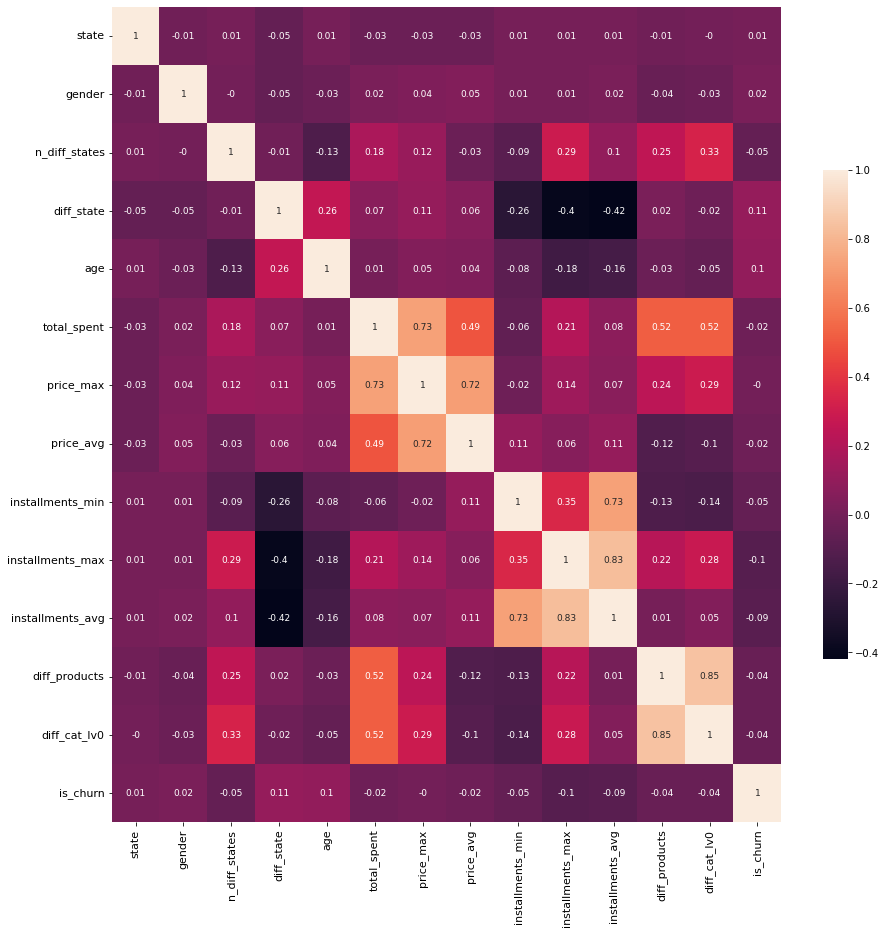

In [ ]:
plt.figure(figsize = (15, 15))
ax = sns.heatmap(df_treino.corr().round(2),
                 annot = True,
                 annot_kws={"size":9},
                 cbar_kws={'shrink': 0.6})
ax.tick_params(labelsize = 11)

Nenhuma das features parece ter relação linear forte com nosso target

## Treinar um Modelo Baseline

Antes de começar a treinar modelos muito complexos, sempre é interessante verificar **se um modelo mais simples já resolve**. Além da vantagem de adquirir mais conhecimento sobre o problema, com modelos simples como [árvores de decisão](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) ou uma boa [regressão logística](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) trazem bons insights sobre o que o modelo aprendeu sobre o problema durante  o treinamento. Com sorte, também é possível ter maior compreensao sobre o **impacto direto de cada _feature_** na decisão de saída do modelo, trazendo uma dimensão de explicabilidade para a solução.


O modelo baseline deve ser avaliado em termos de performance de classificação usando métricas como **F-Score**, **precision**, **recall** e _frameworks_ de avaliação como a **matriz de confusão** e a **curva ROC**. Essas medidas **devem ser colocadas em uma tabela** identificada na primeira linha como **_benchmark_** para que, cada vez que se treinar outro modelo, esse modelo possa ser comparado nessas mesmas métricas com os outros. Um exemplo de tabela de comparação de resultados de modelos está [nessa aula de Balanceamento de _Datasets_](https://docs.google.com/presentation/d/1Y4ORsMqnlP2mYbYG30JwHl_VkIGB0XBdO_D8LmK1OAw/edit?usp=sharing) no **slide 124**.


Importantíssimo: deve-se **sempre verificar se houve _overfit_ ou _underfit_** no treinamento. Uma forma fácil de fazer isso é **comparando métricas de treino e de teste** do mesmo modelo treinado. Assim, fica fácil entender se é necessário resolver problemas de **viés** ou de **variância** nas próximas iterações da construção da solução. 


Um último lembrete: **sempre comparar modelos sobre a mesma massa de teste**. Por esse motivo, o desafio já fornece os dados de teste em um arquivo separado, mas é importantíssimo comparar modelos diferentes sobre o **teste**, que na teoria é um _proxy_ do funcionamento do modleo no mundo real.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

In [ ]:
# definindo X e y treino e teste
X_treino = df_treino.drop('is_churn', axis=1)
y_treino = df_treino['is_churn']

X_teste = df_teste.drop('is_churn', axis=1)
y_teste = df_teste['is_churn']

In [ ]:
# definindo as métricas que serão avaliadas
recall = []
precision = []
f1score = []
roc_auc = []
vn = []
fp = []
fn = []
vp = []

### Decision Tree

In [ ]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_treino, y_treino)
y_predict_dtc = dtc.predict(X_teste)

recall.append(recall_score(y_teste, y_predict_dtc, average=None)[1])
precision.append(precision_score(y_teste, y_predict_dtc, average=None)[1])
f1score.append(f1_score(y_teste, y_predict_dtc, average=None)[1])
roc_auc.append(roc_auc_score(y_teste, y_predict_dtc, average=None))

vneg, fpos, fneg, vpos = confusion_matrix(y_teste, y_predict_dtc).ravel()
vn.append(vneg)
fp.append(fpos)
fn.append(fneg)
vp.append(vpos)

## Treinar Modelos mais Complexos

Após treinar um modelo **_baseline_** e comprender se o problema tem questões de **viés** ou de **variância** (ou ambos) a serem resolvidos, a idéia é treinar modelos mais complexos (e mais fortes) para maximizar a performance da solução. Como os modelos clássicos de _ensemble_ conseguem resolver esses tipos de problemas (e são modelos complexos por si), fica como sugestão a referência da [aula de _Ensembles_](https://docs.google.com/presentation/d/12zwm_gdUrxlY2YpFYTOOPqacyZg_FKqwNaOXGSn6idM/edit?usp=sharing), que sugere os tipos certos de modelos para cada problema.

Algumas sugestões de modelos a serem treinados:

- [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html): _ensemble_ de árvores de decisão do tipo **_bagging_**, diminuem **variância**
- [Gradient Boosted Trees](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html): _ensemble_ de árvores de decisão do tipo **_boosting_**, diminuem **variância** e **viés**
- [Support Vector Machines](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html): modelo com foco na otimização da separação entre as classes, muito eficientes em classificação binária

Lembrando de sempre armazenar na **tabela de resultados** as métricas de cada modelo treinado.


In [ ]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_treino, y_treino)
y_predict_rfc = rfc.predict(X_teste)

recall.append(recall_score(y_teste, y_predict_rfc, average=None)[1])
precision.append(precision_score(y_teste, y_predict_rfc, average=None)[1])
f1score.append(f1_score(y_teste, y_predict_rfc, average=None)[1])
roc_auc.append(roc_auc_score(y_teste, y_predict_rfc, average=None))

vneg, fpos, fneg, vpos = confusion_matrix(y_teste, y_predict_rfc).ravel()
vn.append(vneg)
fp.append(fpos)
fn.append(fneg)
vp.append(vpos)

In [ ]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_treino, y_treino)
y_predict_xgb = xgb.predict(X_teste)

recall.append(recall_score(y_teste, y_predict_xgb, average=None)[1])
precision.append(precision_score(y_teste, y_predict_xgb, average=None)[1])
f1score.append(f1_score(y_teste, y_predict_xgb, average=None)[1])
roc_auc.append(roc_auc_score(y_teste, y_predict_xgb, average=None))

vneg, fpos, fneg, vpos = confusion_matrix(y_teste, y_predict_xgb).ravel()
vn.append(vneg)
fp.append(fpos)
fn.append(fneg)
vp.append(vpos)

In [ ]:
roc_auc

[0.5157057673755598, 0.5018187283120473, 0.5003581661891118]

Tabela de resultados

In [ ]:
df_resultados = pd.DataFrame({'recall':recall,
                              'precision': precision,
                              'fi_score': f1score,
                              'roc_auc': roc_auc,
                              'VN': vn,
                              'FP': fp,
                              'FN': fn,
                              'VP': vp},
                              index = ['Decision Tree Classifier', 'Random Forest Classifier', 'XGBoost'])

In [ ]:
df_resultados

,recall,precision,fi_score,roc_auc,VN,FP,FN,VP
Decision Tree Classifier,0.227077,0.202815,0.214262,0.515706,5122,1246,1079,317
Random Forest Classifier,0.019341,0.212598,0.035456,0.501819,6268,100,1369,27
XGBoost,0.000716,1.000000,0.001432,0.500358,6368,0,1395,1


## Agrupando Modelos em um *Ensemble*

Com vários modelos treinados, é interessante treinar um [_ensemble_ do tipo _stacking_](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html) com os modelos mais promissores dentre os treinados. 


Antes de treinar o _stacking_, deve-se buscar entender **quais modelos são interessantes** para compor esse _ensemble_, já que há bastante custo computacional envolvido em combinar modelos. Uma técnica interessante é **verificar quais modelos são mais complementares** e qual combinação de modelos teria o **potencial ótimo**, i.e. o maior ganho teórico. A primeira parte da [aula de _Ensembles_](https://docs.google.com/presentation/d/12zwm_gdUrxlY2YpFYTOOPqacyZg_FKqwNaOXGSn6idM/edit?usp=sharing) mostra esse racional no **slide 22**.




In [ ]:
''' Espaço reservado para a Solução '''

## Envio das Previsões do Desafio

Após o treinamento, é interessante fazer uma análise da **tabela de resultados** atualizada e compreender a evolução das soluções. Depois, **escolher a melhor solução** e enviar os resultados do modelo sobre os dados em `clients.challenge` para a competição de modelos por [esse formulário]().

O **formato do arquivo** que deve ser submetido é uma tabela com duas colunas:
- `client_id`: todos os IDs de cliente do arquivo *clients.challenge.csv*
- `is_churn`: decisão sobre cada cliente; apenas será aceito o formato binário, com saída igual a `True` ou `False`.

**IMPORTANTE**: por limitações do formulário, o arquivo deve ter extensão `.txt` se for do tipo CSV ou `xls` (ou `xlsx`) se for uma planilha do excel.

In [ ]:
clients_ch

,birthdate,state,gender
client_id,,,
cx12525,1932-04-19,st15,cg1
cx32280,1983-03-01,st15,cg1
cx00471,1964-08-30,st15,cg2
cx18876,1971-04-27,st15,cg2
cx38255,1958-01-26,st15,cg1
...,...,...,...
cx37820,1980-05-01,st04,cg1
cx00770,1964-10-12,st18,cg2
cx01686,1972-07-20,st24,cg2


In [ ]:
clients_ch.reset_index(inplace=True)

In [444]:
clients_ch

,client_id,birthdate,state,gender
0,cx12525,1932-04-19,st15,cg1
1,cx32280,1983-03-01,st15,cg1
2,cx00471,1964-08-30,st15,cg2
3,cx18876,1971-04-27,st15,cg2
4,cx38255,1958-01-26,st15,cg1
...,...,...,...,...
7760,cx37820,1980-05-01,st04,cg1
7761,cx00770,1964-10-12,st18,cg2
7762,cx01686,1972-07-20,st24,cg2
7763,cx06266,1984-12-28,st15,cg2


In [ ]:
df_states_ch_analise = clients_ch.merge(df_test_states, how = 'inner', on = 'client_id')

In [ ]:
df_states_ch_analise

,client_id,birthdate,state,gender,delivery_states,n_diff_states
0,cx12525,1932-04-19,st15,cg1,[st07],1
1,cx32280,1983-03-01,st15,cg1,[st07],1
2,cx00471,1964-08-30,st15,cg2,[st07],1
3,cx18876,1971-04-27,st15,cg2,[st07],1
4,cx38255,1958-01-26,st15,cg1,[st07],1
...,...,...,...,...,...,...
7760,cx37820,1980-05-01,st04,cg1,[st04],1
7761,cx00770,1964-10-12,st18,cg2,[st07],1
7762,cx01686,1972-07-20,st24,cg2,"[st24, st07]",2
7763,cx06266,1984-12-28,st15,cg2,"[st15, st07]",2


In [ ]:
df_states_ch_analise['diff_state'] = 1
for i in range(len(df_states_ch_analise.index)):
  if df_states_ch_analise['delivery_states'][i][0] == df_states_ch_analise['state'][i]:
    df_states_ch_analise['diff_state'][i] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# criando a feature de idade, com base no ano de nascimento.
df_states_ch_analise['age'] = 2022 - df_states_ch_analise['birthdate'].dt.year

In [ ]:
df_states_ch_analise

,client_id,birthdate,state,gender,delivery_states,n_diff_states,diff_state,age
0,cx12525,1932-04-19,st15,cg1,[st07],1,1,90
1,cx32280,1983-03-01,st15,cg1,[st07],1,1,39
2,cx00471,1964-08-30,st15,cg2,[st07],1,1,58
3,cx18876,1971-04-27,st15,cg2,[st07],1,1,51
4,cx38255,1958-01-26,st15,cg1,[st07],1,1,64
...,...,...,...,...,...,...,...,...
7760,cx37820,1980-05-01,st04,cg1,[st04],1,0,42
7761,cx00770,1964-10-12,st18,cg2,[st07],1,1,58
7762,cx01686,1972-07-20,st24,cg2,"[st24, st07]",2,0,50
7763,cx06266,1984-12-28,st15,cg2,"[st15, st07]",2,0,38


In [ ]:
# total gasto
tmp = pd.DataFrame({'total_spent':orders_product_analise.groupby('client_id')['price'].sum()}).reset_index()
df_states_ch_analise = df_states_ch_analise.merge(tmp, how = 'inner', on = 'client_id')

In [ ]:
df_states_ch_analise

,client_id,birthdate,state,gender,delivery_states,n_diff_states,diff_state,age,total_spent
0,cx12525,1932-04-19,st15,cg1,[st07],1,1,90,378.09
1,cx32280,1983-03-01,st15,cg1,[st07],1,1,39,920.21
2,cx00471,1964-08-30,st15,cg2,[st07],1,1,58,312.67
3,cx18876,1971-04-27,st15,cg2,[st07],1,1,51,8670.07
4,cx38255,1958-01-26,st15,cg1,[st07],1,1,64,2148.30
...,...,...,...,...,...,...,...,...,...
7760,cx37820,1980-05-01,st04,cg1,[st04],1,0,42,277.70
7761,cx00770,1964-10-12,st18,cg2,[st07],1,1,58,344.40
7762,cx01686,1972-07-20,st24,cg2,"[st24, st07]",2,0,50,487.57
7763,cx06266,1984-12-28,st15,cg2,"[st15, st07]",2,0,38,2806.80


In [ ]:
# preço máximo
tmp = pd.DataFrame({'price_max':orders_product_analise.groupby('client_id')['price'].max()}).reset_index()
df_states_ch_analise = df_states_ch_analise.merge(tmp, how = 'inner', on = 'client_id')

In [ ]:
# preço médio
tmp = pd.DataFrame({'price_avg':orders_product_analise.groupby('client_id')['price'].mean()}).reset_index()
df_states_ch_analise = df_states_ch_analise.merge(tmp, how = 'inner', on = 'client_id')

In [ ]:
# Parcelamentos
tmp = pd.DataFrame({'installments_min':orders_product_analise.groupby('client_id')['installments'].min()}).reset_index()
df_states_ch_analise = df_states_ch_analise.merge(tmp, how = 'inner', on = 'client_id')

tmp = pd.DataFrame({'installments_max':orders_product_analise.groupby('client_id')['installments'].max()}).reset_index()
df_states_ch_analise = df_states_ch_analise.merge(tmp, how = 'inner', on = 'client_id')

tmp = pd.DataFrame({'installments_avg':orders_product_analise.groupby('client_id')['installments'].mean()}).reset_index()
df_states_ch_analise = df_states_ch_analise.merge(tmp, how = 'inner', on = 'client_id')

In [ ]:
# produtos diferentes
tmp = pd.DataFrame({'diff_products':orders_product_analise.groupby('client_id')['product_id'].nunique()}).reset_index()
df_states_ch_analise = df_states_ch_analise.merge(tmp, how = 'inner', on = 'client_id')

In [ ]:
# nível produto 0
tmp = pd.DataFrame({'diff_cat_lv0':orders_product_analise.groupby('client_id')['category_lv0'].nunique()}).reset_index()
df_states_ch_analise = df_states_ch_analise.merge(tmp, how = 'inner', on = 'client_id')

In [ ]:
# removendo as features não importantes
df_states_ch_analise = df_states_ch_analise.drop(['client_id', 'birthdate', 'delivery_states'], axis = 1)
df_states_ch_analise

,state,gender,n_diff_states,diff_state,age,total_spent,price_max,price_avg,installments_min,installments_max,installments_avg,diff_products,diff_cat_lv0
0,st15,cg1,1,1,90,378.09,126.74,75.618000,NaN,NaN,NaN,5,2
1,st15,cg1,1,1,39,920.21,529.00,230.052500,NaN,NaN,NaN,4,3
2,st15,cg2,1,1,58,312.67,408.88,39.083750,NaN,NaN,NaN,6,3
3,st15,cg2,1,1,51,8670.07,2298.96,867.007000,NaN,NaN,NaN,8,5
4,st15,cg1,1,1,64,2148.30,1799.28,716.100000,NaN,NaN,NaN,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7760,st04,cg1,1,0,42,277.70,112.90,92.566667,NaN,NaN,NaN,3,3
7761,st18,cg2,1,1,58,344.40,160.50,86.100000,NaN,NaN,NaN,4,4
7762,st24,cg2,2,0,50,487.57,359.10,121.892500,2.0,5.0,3.0,3,3
7763,st15,cg2,2,0,38,2806.80,899.00,400.971429,NaN,NaN,NaN,7,4


In [ ]:
# parcelamento
df_states_ch_analise.installments_min.fillna(0, inplace=True)
df_states_ch_analise.installments_max.fillna(0, inplace=True)
df_states_ch_analise.installments_avg.fillna(0, inplace=True)

In [ ]:
# primeiro, vamos encodar gender do modo mais fácil
dict = {'cg1':0,
        'cg2':1}
df_states_ch_analise.gender = df_states_ch_analise.gender.map(dict)

In [ ]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
feature_oe = ['state']

# preprocessamento ordinal encoders
df_states_ch_analise[feature_oe] = oe.fit_transform(df_states_ch_analise[feature_oe])

In [ ]:
df_states_ch_analise = df_states_ch_analise[['state', 'gender', 'n_diff_states', 'diff_state', 'age',
       'total_spent', 'price_max', 'price_avg', 'installments_min',
       'installments_max', 'installments_avg', 'diff_products',
       'diff_cat_lv0']]

In [ ]:
X_test_ch = df_states_ch_analise.copy()

In [ ]:
y_predict_dtc = dtc.predict(X_test_ch)

In [ ]:
y_predict_dtc

array([0, 1, 0, ..., 1, 0, 0])

In [445]:
resultado = pd.DataFrame({'client_id':clients_ch.client_id,
                          'is_churn':y_predict_dtc})

In [446]:
resultado

,client_id,is_churn
0,cx12525,0
1,cx32280,1
2,cx00471,0
3,cx18876,1
4,cx38255,1
...,...,...
7760,cx37820,0
7761,cx00770,0
7762,cx01686,1
7763,cx06266,0


In [447]:

dict = {0: 'False',
        1: 'True'}
resultado.is_churn = resultado.is_churn.map(dict)

In [448]:
resultado

,client_id,is_churn
0,cx12525,False
1,cx32280,True
2,cx00471,False
3,cx18876,True
4,cx38255,True
...,...,...
7760,cx37820,False
7761,cx00770,False
7762,cx01686,True
7763,cx06266,False


## Insights & Levantamento de Hipóteses

Durante o desenvolvimento das soluções e as explorações, é muito provável que alguns _insights_ e hipóteses tenham surgido. Nessa última etapa é o momento de escrever eses pontos de forma estruturada e preparar o **banco de hipóteses** para mais uma rodada de solução. Afinal, se há espaço para melhoras, esse banco pode ser uma fonte de boas idéias de onde começar.